In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-08-10 14:33:47.876254: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-10 14:33:47.908278: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 14:33:47.965087: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 14:33:47.965255: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6151238301893695034
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5983371264
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17785809928574482872
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:2b:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

ysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 14:33:48.502062: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 14:33:48.502166: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /device:GPU:0 with 5706 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:2b:00.0, compute capability: 8.6


In [2]:
import h5py
# load dataset
h5 = h5py.File('./data/NG_stage23_08032022.hdf5', mode='r')
dataset = h5.get('phi')

# shuffle dataset
data_sz = dataset.shape[0]
print(f"Selected number of cases: {data_sz}")
indexes = np.arange(data_sz)
np.random.shuffle(indexes)
train_index = np.sort(indexes[: int(0.75 * data_sz)])
val_index = np.sort(indexes[int(0.75 * data_sz) :])

# check dataset size
print(f'Dataset shape is: {dataset.shape}')
train_dataset = np.take(dataset,train_index,axis=0)
print(f'Splitted trainning dataset shape is: {train_dataset.shape}')
val_dataset = np.take(dataset,val_index,axis=0)
print(f'Splitted trainning dataset shape is: {val_dataset.shape}')

Selected number of cases: 91
Dataset shape is: (91, 111, 150, 150, 5)
Splitted trainning dataset shape is: (68, 111, 150, 150, 5)
Splitted trainning dataset shape is: (23, 111, 150, 150, 5)


In [3]:
from tqdm import tqdm

def create_shifted_frames_many2one(dataset,numFrames):
    sz = dataset.shape[0]*(dataset.shape[1]-numFrames)
    x = np.zeros([sz, numFrames, dataset.shape[2],dataset.shape[3], 5])
    y = np.zeros([sz, 2, dataset.shape[2],dataset.shape[3], 5])
    k = 0
    for i in tqdm(range(dataset.shape[0]), desc="Running ..."):
        for j in range(dataset.shape[1]-numFrames):
            currentFrame = np.expand_dims(np.expand_dims(dataset[i,j+numFrames,...],axis=0),axis=0)
            pastFrames = np.expand_dims(dataset[i,j:(j+numFrames),...],axis=0)
            x[k,...] = pastFrames
            y[k,0,...] = currentFrame
            y[k,1,...] = pastFrames[:,-1,...] # passing past frame to ground truth for use in loss function (an issue with directly passing inp into loss func)
            k+=1  
    return x,y

def create_shifted_frames_many2one_append(dataset,numFrames):
    for i in tqdm(range(dataset.shape[0]), desc="Running ..."):
        for j in range(dataset.shape[1]-numFrames):
            currentFrame = np.expand_dims(np.expand_dims(dataset[i,j+numFrames,...],axis=0),axis=0)
            pastFrames = np.expand_dims(dataset[i,j:(j+numFrames),...],axis=0)
            if np.amax(currentFrame[...,1])<1 or np.amax(pastFrames[:,0,:,:,1])<1 \
                or np.amax(pastFrames[:,1,:,:,1])<1 or np.amax(pastFrames[:,2,:,:,1])<1 \
                    or np.amax(pastFrames[:,3,:,:,1])<1 or np.amax(pastFrames[:,4,:,:,1])<1:
            # if np.amax(currentFrame[...,1])<1:
                pass
            else:
                try:
                    x = np.append(x,pastFrames,axis=0)
                    y = np.append(y,currentFrame,axis=0)
                    y1 = np.append(y1,pastFrames[:,-1,...],axis=0)
                except:
                    x = pastFrames
                    y = currentFrame
                    y1 = pastFrames[:,-1,...]
    y = np.concatenate((y,np.expand_dims(y1,axis=1)),axis=1)
    return x,y

# creatign many to 1 shifted trainning and validation dataset
numFrames = 5
x_train, y_train = create_shifted_frames_many2one(train_dataset,numFrames)
x_val, y_val = create_shifted_frames_many2one(val_dataset,numFrames)

# increase tubulin magnitude (actual value too small)
x_train[...,2] = x_train[...,2]
y_train[...,2] = y_train[...,2]
x_val[...,2] = x_val[...,2]
y_val[...,2] = y_val[...,2]

print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

# some wierd memory issue with tensorflow, same batch size with smaller dataset size works
x_train = np.take(x_train,np.arange(1200),axis=0)
y_train = np.take(y_train,np.arange(1200),axis=0)
x_val = np.take(x_val,np.arange(400),axis=0)
y_val = np.take(y_val,np.arange(400),axis=0)

print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Running ...: 100%|██████████| 23/23 [00:11<00:00,  1.97it/s]


Training Dataset Shapes: (7208, 5, 150, 150, 5), (7208, 2, 150, 150, 5)
Validation Dataset Shapes: (2438, 5, 150, 150, 5), (2438, 2, 150, 150, 5)
Training Dataset Shapes: (1200, 5, 150, 150, 5), (1200, 2, 150, 150, 5)
Validation Dataset Shapes: (400, 5, 150, 150, 5), (400, 2, 150, 150, 5)


In [4]:
# x_train = np.load("x_train_0803.npy")
# y_train = np.load("y_train_0803.npy")
# x_val = np.load("x_val_0803.npy")
# y_val = np.load("y_val_0803.npy")

# # some wierd memory issue with tensorflow, same batch size with smaller dataset size works
# x_train = np.take(x_train,np.arange(1200),axis=0)
# y_train = np.take(y_train,np.arange(1200),axis=0)
# x_val = np.take(x_val,np.arange(400),axis=0)
# y_val = np.take(y_val,np.arange(400),axis=0)

# numFrames = x_train.shape[1]
# print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
# print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

(1200, 5, 150, 150, 5)
537


Text(0.5, 1.0, 'Goal Frame 5')

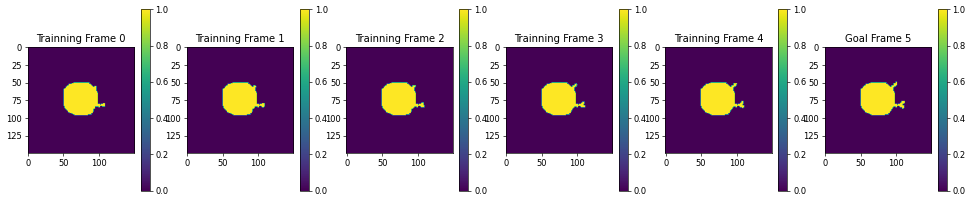

In [5]:
print(x_train.shape)
data_choice = np.random.choice(range(len(x_train)), size=1)[0]
print(data_choice)
channel = 0
plt.figure(figsize=(20, 4), dpi=60)
for i in range(numFrames):
    plt.subplot(1,numFrames+1,i+1)
    plt.imshow(x_train[data_choice,i,:,:,channel])
    plt.colorbar()
    plt.title(f"Trainning Frame {i}")

plt.subplot(1,numFrames+1,numFrames+1)
plt.imshow(y_train[data_choice,0,:,:,channel])
plt.colorbar()
plt.title(f"Goal Frame {numFrames}")

In [6]:
# function to calculate partial derivatives of the input
def get_deriv(input):
    N1N_input, NN1_input = tf.image.image_gradients(input)
    N2N_input, _ = tf.image.image_gradients(N1N_input)
    _, NN2_input = tf.image.image_gradients(NN1_input)
    LAP_input = tf.math.add(N2N_input,NN2_input)
    return N1N_input, NN1_input, N2N_input, NN2_input, LAP_input

# calculate MSE
def get_MSE_tf(input,goal):
    return tf.math.reduce_mean(tf.square(tf.math.subtract(input, goal)),axis=[1,2])

def get_MAE_tf(input,goal):
    return tf.math.sqrt(tf.math.reduce_mean(tf.math.square(input-goal),axis=[1,2]))

def get_MRE_tf(input,goal):
    return tf.math.divide(get_MAE_tf(input,goal),(tf.math.reduce_max(goal,axis=[1,2])-tf.math.reduce_min(goal,axis=[1,2])))

def get_scaled_Residual_across_batch(input_residual):
    # hard coded for batch
    print(input_residual.shape)
    residual_0 = tf.expand_dims(tf.expand_dims(tf.math.divide(input_residual[0,:,:,0],tf.math.reduce_max(input_residual[0,:,:,0])),axis=0),axis=3)
    residual_1 = tf.expand_dims(tf.expand_dims(tf.math.divide(input_residual[1,:,:,0],tf.math.reduce_max(input_residual[1,:,:,0])),axis=0),axis=3)
    residual_2 = tf.expand_dims(tf.expand_dims(tf.math.divide(input_residual[2,:,:,0],tf.math.reduce_max(input_residual[2,:,:,0])),axis=0),axis=3)
    residual_3 = tf.expand_dims(tf.expand_dims(tf.math.divide(input_residual[3,:,:,0],tf.math.reduce_max(input_residual[3,:,:,0])),axis=0),axis=3)
    residual_4 = tf.expand_dims(tf.expand_dims(tf.math.divide(input_residual[4,:,:,0],tf.math.reduce_max(input_residual[4,:,:,0])),axis=0),axis=3)
    residual_5 = tf.expand_dims(tf.expand_dims(tf.math.divide(input_residual[5,:,:,0],tf.math.reduce_max(input_residual[5,:,:,0])),axis=0),axis=3)
    return tf.reduce_mean(tf.concat((residual_0,residual_1,residual_2,residual_3,residual_4,residual_5),axis=0),axis=[1,2])
    
# PINN - physics-informed loss function for Phase-field neuron growth model
def PINN_loss():
    def loss(y_true, y_pred):
        # dt = 0.01*500 # current data sampled per 500 iter (change based on dataset)

        # # extract variables from ground truth
        true_phi = tf.expand_dims(y_true[:,0,:,:,0],axis=3)
        # true_tips = tf.expand_dims(y_true[:,0,:,:,1],axis=3)
        true_tub = tf.expand_dims(y_true[:,0,:,:,2],axis=3)
        true_tempr = tf.expand_dims(y_true[:,0,:,:,3],axis=3)
        # theta = tf.expand_dims(y_true[:,0,:,:,4],axis=3) # Since theta is passed, theta remains the same
        # # # extract variables from previous iteration (intentionally placed in ground truth so it is easier to access)
        # # NN_p = tf.expand_dims(inp[:,-1,:,:,0],axis=3)
        # # tips_p = tf.expand_dims(inp[:,-1,:,:,1],axis=3)
        # # tub_p = tf.expand_dims(inp[:,-1,:,:,2],axis=3)
        # # tempr_p = tf.expand_dims(inp[:,-1,:,:,3],axis=3)
        # # extract variables from previous iteration (intentionally placed in ground truth so it is easier to access)
        # NN_p = tf.expand_dims(y_true[:,1,:,:,0],axis=3)
        # tips_p = tf.expand_dims(y_true[:,1,:,:,1],axis=3)
        # tub_p = tf.expand_dims(y_true[:,1,:,:,2],axis=3)
        # tempr_p = tf.expand_dims(y_true[:,1,:,:,3],axis=3)
        # extract variables from prediction
        NN_pK = tf.expand_dims(y_pred[:,-1,:,:,0],axis=3)
        # tips_pK = tf.expand_dims(y_pred[:,-1,:,:,1],axis=3)
        tub_pK = tf.expand_dims(y_pred[:,-1,:,:,2],axis=3)
        tempr_pK = tf.expand_dims(y_pred[:,-1,:,:,3],axis=3)
        # # calc corresponding partial derivatives
        # N1N_p, NN1_p, _, _, LAP_p = get_deriv(NN_p)
        # N1N_theta, NN1_theta, _, _, _ = get_deriv(theta)
        # # _, _, _, _, LAP_tp = get_deriv(tempr_p)
        # # N1N_tb, NN1_tb, _, _, LAP_tb = get_deriv(tub_p)

        # # # Temperature residual
        # # tempr_residual = (3*LAP_tp+4*(NN_pK - NN_p)/dt)*dt + tempr_p - tempr_pK

        # # # Tubulin residual
        # # diff_tb = 4*(tf.math.multiply(N1N_p,N1N_tb) + tf.math.multiply(NN1_p,NN1_tb) + tf.math.multiply(NN_p,LAP_tb))
        # # alph_tb = 0.001*(tf.math.multiply(N1N_p,tub_p) + tf.math.multiply(NN_p,N1N_tb) + tf.math.multiply(NN1_p,tub_p) + tf.math.multiply(NN_p,NN1_tb))
        # # beta_tb = 0.001*tf.math.multiply(NN_p,tub_p)
        # # src_tb = tf.math.divide_no_nan(15*tf.math.square(LAP_p),tf.math.reduce_sum(tf.math.square(LAP_p)))
        # # tub_residual = (diff_tb - alph_tb - beta_tb + src_tb)*dt + tub_p - tub_pK

        # # phase field residual
        # e = 0.2865*tf.math.atan(10*tf.math.multiply(tf.math.multiply(tips_p,5*tub_pK-0.1),1-tempr_pK)) # energy equation
        # atheta = tf.math.atan2(NN1_p,N1N_p)
        # a = 0.04*(1.0+0.1*tf.math.cos(6*(atheta-theta)))
        # ap = -0.04*(6*0.1*tf.math.sin(6*(atheta-theta)))
        # aap = tf.math.multiply(a,ap)
        # a2 = tf.math.square(a)
        # a2Lap = tf.math.multiply(a2,LAP_p)
        # N1N_aapNN1p, _ = tf.image.image_gradients(tf.math.multiply(aap,NN1_p))
        # _, NN1_aapN1Np = tf.image.image_gradients(tf.math.multiply(aap,N1N_p))
        # mag_theta = tf.math.sqrt(tf.math.square(N1N_theta) + tf.math.square(NN1_theta))
        # dblwll_term = tf.math.multiply(tf.math.multiply(NN_p,1-NN_p),NN_p - 0.5 + e + 6*0.007*mag_theta)
        # phi_residual = a2Lap - N1N_aapNN1p + NN1_aapN1Np + dblwll_term - (NN_pK - NN_p) / dt

        # calculate mean of each residual and mse of prediction and ground truth
        # residual_mse = tf.math.reduce_mean(phi_residual) + tf.math.reduce_mean(tempr_residual) + tf.math.reduce_mean(tub_residual)
        
        # residual_0 = tf.expand_dims(tf.expand_dims(tf.math.divide(phi_residual[0,:,:,0],tf.math.reduce_max(phi_residual[0,:,:,0])),axis=0),axis=3)
        # residual_0 = tf.expand_dims(tf.expand_dims(phi_residual[0,:,:,0],axis=0),axis=3)
        # residual_mse = tf.reduce_mean(tf.concat((residual_0),axis=0),axis=[1,2])
        # print(phi_residual.shape)
        # residual_mse = tf.reduce_mean(phi_residual,axis=[1,2])
        # residual_mse = get_scaled_Residual_across_batch(phi_residual)
        # print(residual_mse.shape)

        # diff_phi = get_MSE_tf(NN_pK,true_phi)
        # print(NN_pK.shape)
        # print(true_phi.shape)
        # print(diff_phi.shape)
        # print(tf.math.subtract(NN_pK, true_phi).shape)
        # print(tf.square(tf.math.subtract(NN_pK, true_phi)).shape)
        # print(tf.math.reduce_mean(tf.square(tf.math.subtract(NN_pK, true_phi)),axis=[1,2]).shape)
        # phi_max = tf.math.reduce_max(diff_phi,axis=[1,2])
        # diff_tips = get_MSE_tf(tips_pK,true_tips)
        # tips_max = tf.math.reduce_max(diff_tips,axis=[1,2])
        # diff_tempr = get_MRE_tf(tempr_pK,true_tempr)
        # tempr_max = tf.math.reduce_max(diff_tempr,axis=[1,2])
        # diff_tub = get_MRE_tf(tub_pK,true_tub)
        # tub_max = tf.math.reduce_max(diff_tub,axis=[1,2])

        # diff_mse = get_MSE_tf(NN_pK,true_phi) + get_MSE_tf(tips_pK,true_tips) + get_MRE_tf(tempr_pK,true_tempr) + get_MRE_tf(tub_pK,true_tub)
        diff_mse = get_MSE_tf(NN_pK,true_phi) + get_MRE_tf(tempr_pK,true_tempr) + get_MRE_tf(tub_pK,true_tub)
        # diff_mse = tf.math.divide(diff_phi,phi_max) + tf.math.divide(diff_tips,tips_max) + tf.math.divide(diff_tempr,tempr_max) + tf.math.divide(diff_tub,tub_max)

        # return tf.math.abs(residual_mse) + tf.math.abs(diff_mse)
        # return residual_mse + diff_mse
        return tf.math.abs(diff_mse)
        # return tf.math.abs(diff_mse)
    return loss

In [7]:
from tensorflow.keras import layers
inp = layers.Input(shape=(x_train.shape[1:]))

# Separable Convolution Encoding
x0 = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    strides = (2, 2),
    padding="valid",
    return_sequences=True,
    activation="relu",
    # recurrent_dropout=drop_rate,
)(inp)
# recurrent cell, 5 time step to 1 time step
x2 = layers.ConvLSTM2D(
    filters=128,
    kernel_size=(5, 5),
    strides = (2, 2),
    padding="valid",
    return_sequences=False,
    activation="relu",
    # recurrent_dropout=0.2,
)(x0)

# decoding for phi channel
phi1 = x2
phi2 = layers.Conv2DTranspose(
    filters=64,
    kernel_size=(5, 5),
    strides = (2, 2),
    padding="valid",
    activation="relu",
)(phi1)
phi3 = layers.Conv2DTranspose(
    filters=1,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="sigmoid",
)(phi2)

# decoding for tublin channel
tub1 = x2
tub2 = layers.Conv2DTranspose(
    filters=64,
    kernel_size=(5, 5),
    strides = (2, 2),
    padding="valid",
    activation="relu",
    use_bias=True,
)(tub1)
tub3 = layers.Conv2DTranspose(
    filters=1,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="relu",
    use_bias=True,
)(tub2)
tub4 = tf.math.multiply(phi3,tub3)

# decoding for temperature channel
tempr1 = x2
tempr2 = layers.Conv2DTranspose(
    filters=64,
    kernel_size=(5, 5),
    strides = (2, 2),
    padding="valid",
    activation="relu",
    use_bias=True,
)(tempr1)
tempr3 = layers.Conv2DTranspose(
    filters=1,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="relu",
    use_bias=True,
)(tempr2)
phi_pre = tf.expand_dims(inp[:,-1,:,:,0],axis=3)
tempr3 = tf.concat([tempr3, phi3-phi_pre],axis=3)
tempr4 = layers.Conv2D(
    filters=1,
    kernel_size=(6, 6),
    strides = (1, 1),
    padding="same",
    activation="relu",
    use_bias=True,
)(tempr3)

# passing theta (no change)
theta1 = tf.expand_dims(inp[:,0,:,:,-1],axis=3)
tip5 = tf.expand_dims(inp[:,0,:,:,1],axis=3)

# tip0 = layers.Conv2D(
#     filters=64,
#     kernel_size=(4, 4),
#     strides = (1, 1),
#     padding="valid",
#     activation="relu",
# )(phi3)
# tip1 = layers.MaxPooling2D(
#     pool_size=(2, 2),
#     strides=None, 
#     padding="valid"
# )(tip0)
# tip2 = layers.Conv2D(
#     filters=128,
#     kernel_size=(4, 4),
#     strides = (1, 1),
#     padding="valid",
#     activation="relu",
# )(tip1)
# tip3 = layers.MaxPooling2D(
#     pool_size=(2, 2),
#     strides=None, 
#     padding="valid"
# )(tip2)

# tip4 = layers.Conv2DTranspose(
#     filters=64,
#     kernel_size=(5, 5),
#     strides = (2, 2),
#     padding="valid",
#     activation="relu",
# )(tip3)
# tip5 = layers.Conv2DTranspose(
#     filters=1,
#     kernel_size=(6, 6),
#     strides = (2, 2),
#     padding="valid",
#     activation="sigmoid",
# )(tip4)

# concat all to generate output
out = tf.expand_dims(tf.concat([phi3,tip5,tub4,tempr4,theta1],axis=3),axis=1)

2022-08-10 14:36:00.300290: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 14:36:00.302113: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 14:36:00.302232: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 14:36:00.306816: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 14:36:00.306940: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [8]:
model = keras.models.Model(inp, out)
model.compile(
    loss=PINN_loss(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    )
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 150, 150  0           []                               
                                , 5)]                                                             
                                                                                                  
 conv_lstm2d (ConvLSTM2D)       (None, 5, 73, 73, 6  441856      ['input_1[0][0]']                
                                4)                                                                
                                                                                                  
 conv_lstm2d_1 (ConvLSTM2D)     (None, 35, 35, 128)  2458112     ['conv_lstm2d[0][0]']            
                                                                                              

In [9]:
import gc
gc.collect()

2059

In [10]:
test = False

if test == True:
    model = keras.models.load_model('./saved_model/model_conv_lstm_test_42_MSE', custom_objects={'loss': PINN_loss()})
else: 
    early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=15)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='TB_logDir_42_MSE', histogram_freq=1)
    with tf.device('/device:GPU:0'):
        model.fit(
            x_train,
            y_train,
            batch_size=6,
            epochs=1000,
            validation_data=(x_val, y_val),
            callbacks=[early_stopping, reduce_lr, tensorboard_callback],
        )
    model.save('./saved_model/model_conv_lstm_test_42_MSE') 

Epoch 1/1000


2022-08-10 14:36:08.136291: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'Func/gradient_tape/model/conv_lstm2d_1/while/model/conv_lstm2d_1/while_grad/body/_367/input/_1025' -> 'gradient_tape/model/conv_lstm2d_1/while/model/conv_lstm2d_1/while_grad/body/_367/gradient_tape/model/conv_lstm2d_1/while/gradients/AddN', 'model/conv_lstm2d_1/while/body/_179/model/conv_lstm2d_1/while/mul_2' -> 'model/conv_lstm2d_1/while/body/_179/model/conv_lstm2d_1/while/add_5', 'model/conv_lstm2d_1/while/body/_179/model/conv_lstm2d_1/while/clip_by_value' -> 'model/conv_lstm2d_1/while/body/_179/model/conv_lstm2d_1/while/mul_3', 'model/conv_lstm2d_1/while/body/_179/model/conv_lstm2d_1/while/clip_by_value_2' -> 'model/conv_lstm2d_1/while/body/_179/model/conv_lstm2d_1/while/mul_5', 'model/conv_lstm2d_1/while/body/_179/model/conv_lstm2d_1/while/convolution_6' -> 'model/conv_lstm2d_1/while

200/200 [==============================] - 37s 158ms/step - loss: 0.4728 - val_loss: 0.3442 - lr: 1.0000e-04
Epoch 2/1000
  1/200 [..............................] - ETA: 27s - loss: 0.4429

2022-08-10 14:36:42.961496: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 52.81MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-08-10 14:36:42.961588: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 52.81MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-08-10 14:36:42.964356: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 52.81MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-08-10 14:36:42.964441: W tensorflow/core/common_runtime/bfc_alloc

200/200 [==============================] - 33s 164ms/step - loss: 0.3100 - val_loss: 0.2647 - lr: 1.0000e-04
Epoch 3/1000
200/200 [==============================] - 32s 159ms/step - loss: 0.2240 - val_loss: 0.1892 - lr: 1.0000e-04
Epoch 4/1000
200/200 [==============================] - 32s 159ms/step - loss: 0.1726 - val_loss: 0.1586 - lr: 1.0000e-04
Epoch 5/1000
200/200 [==============================] - 32s 159ms/step - loss: 0.1477 - val_loss: 0.1524 - lr: 1.0000e-04
Epoch 6/1000
200/200 [==============================] - 33s 165ms/step - loss: 0.1331 - val_loss: 0.1362 - lr: 1.0000e-04
Epoch 7/1000
200/200 [==============================] - 32s 160ms/step - loss: 0.1157 - val_loss: 0.1201 - lr: 1.0000e-04
Epoch 8/1000
200/200 [==============================] - 32s 159ms/step - loss: 0.1027 - val_loss: 0.1004 - lr: 1.0000e-04
Epoch 9/1000
200/200 [==============================] - 32s 159ms/step - loss: 0.0886 - val_loss: 0.0894 - lr: 1.0000e-04
Epoch 10/1000
200/200 [==============

INFO:tensorflow:Assets written to: ./saved_model/model_conv_lstm_test_42_MSE/assets


INFO:tensorflow:Assets written to: ./saved_model/model_conv_lstm_test_42_MSE/assets


Random case: 9


Plotting and Saving figures ...:   0%|          | 0/34 [00:00<?, ?it/s]

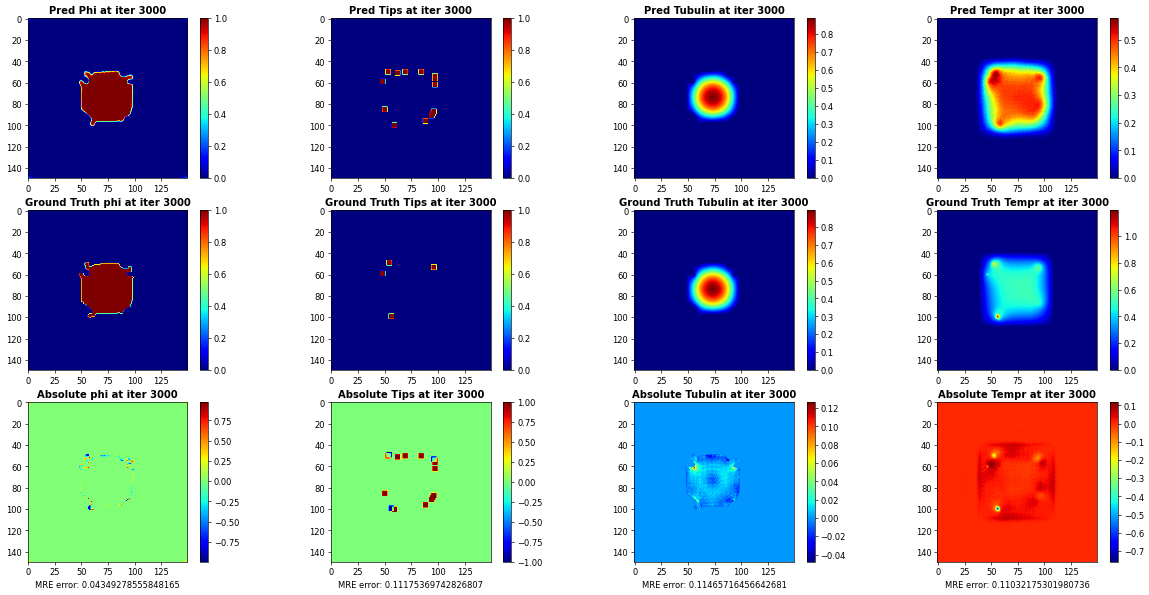

Plotting and Saving figures ...:   3%|▎         | 1/34 [00:02<01:23,  2.52s/it]

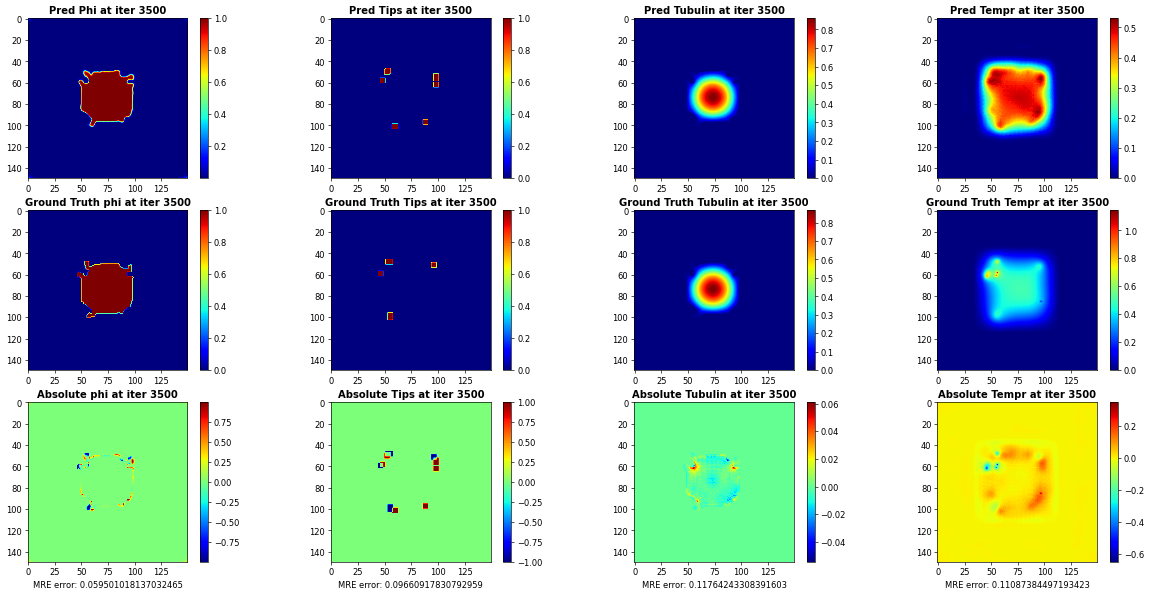

Plotting and Saving figures ...:   6%|▌         | 2/34 [00:03<00:58,  1.83s/it]

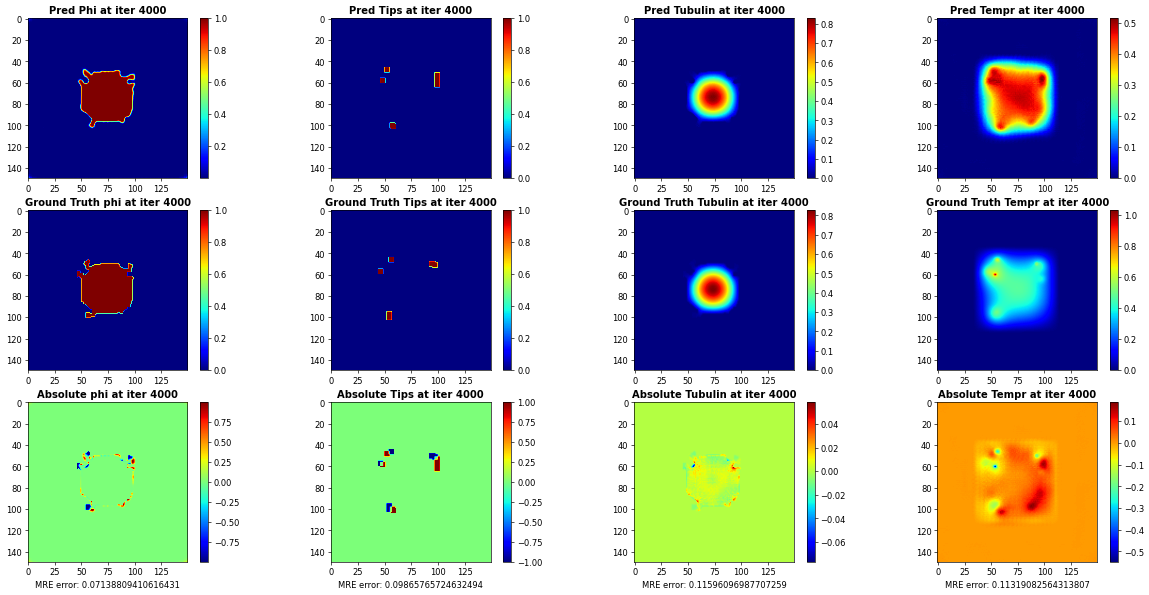

Plotting and Saving figures ...:   9%|▉         | 3/34 [00:05<00:48,  1.56s/it]

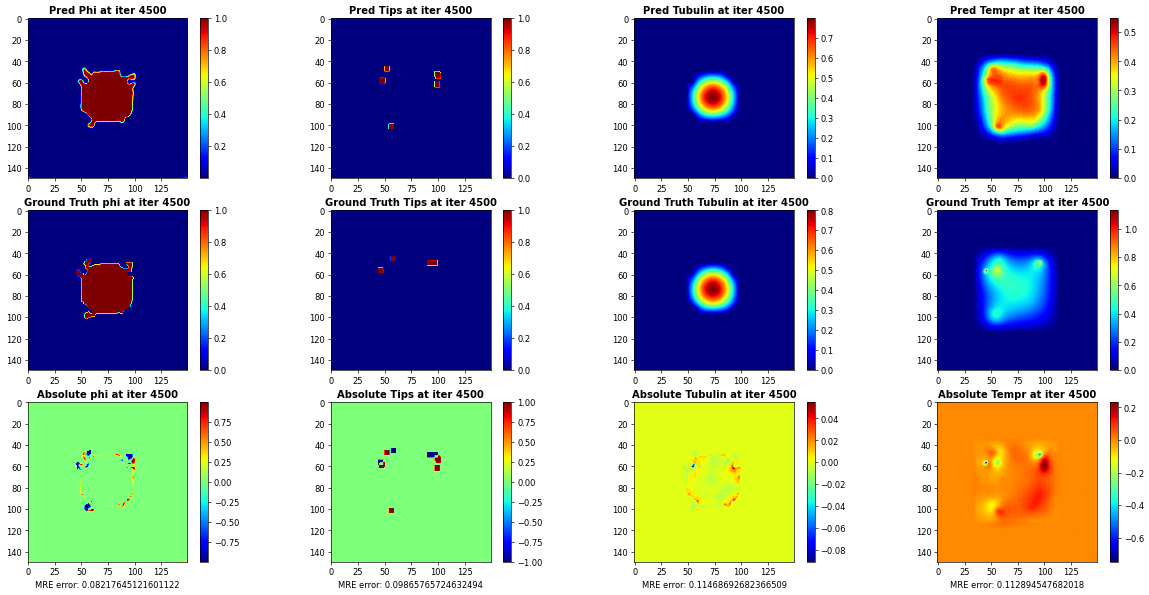

Plotting and Saving figures ...:  12%|█▏        | 4/34 [00:06<00:41,  1.38s/it]

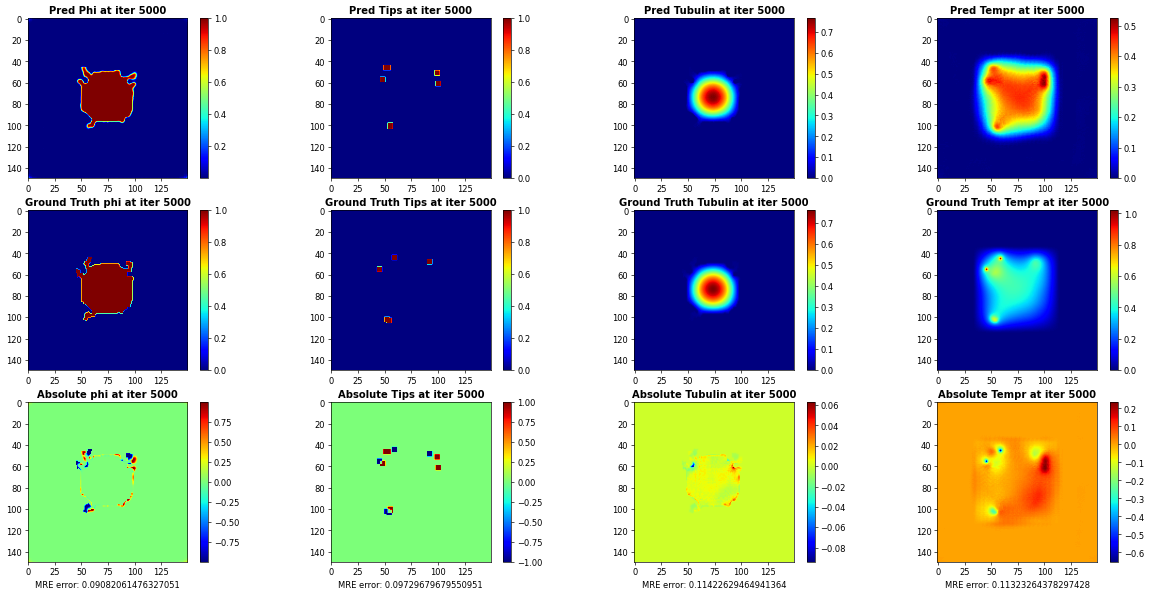

Plotting and Saving figures ...:  15%|█▍        | 5/34 [00:07<00:39,  1.36s/it]

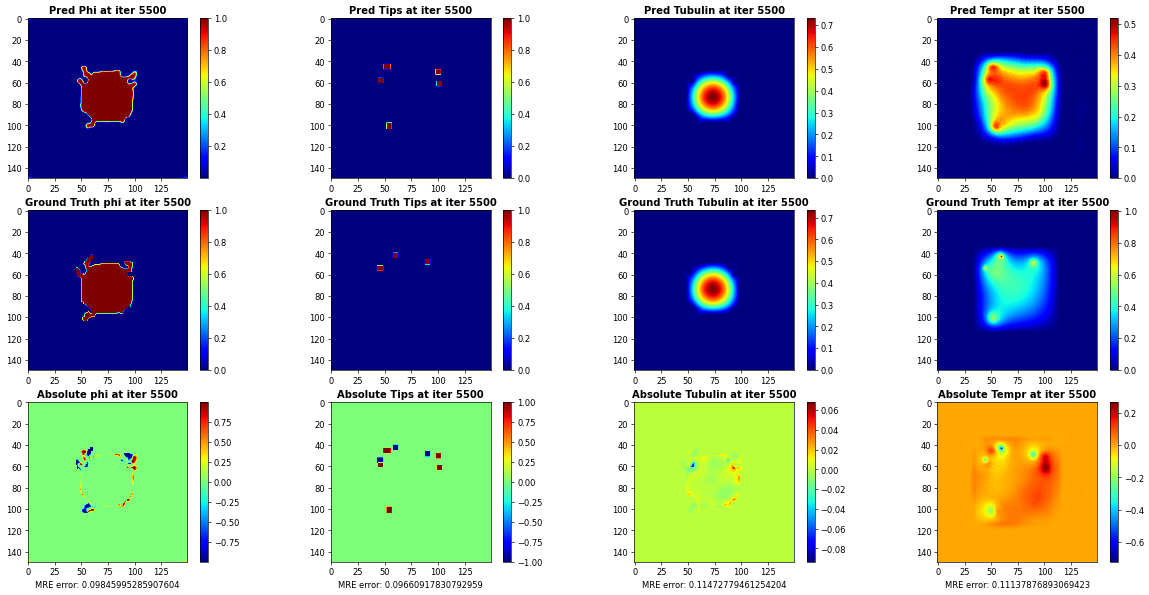

Plotting and Saving figures ...:  18%|█▊        | 6/34 [00:08<00:35,  1.27s/it]

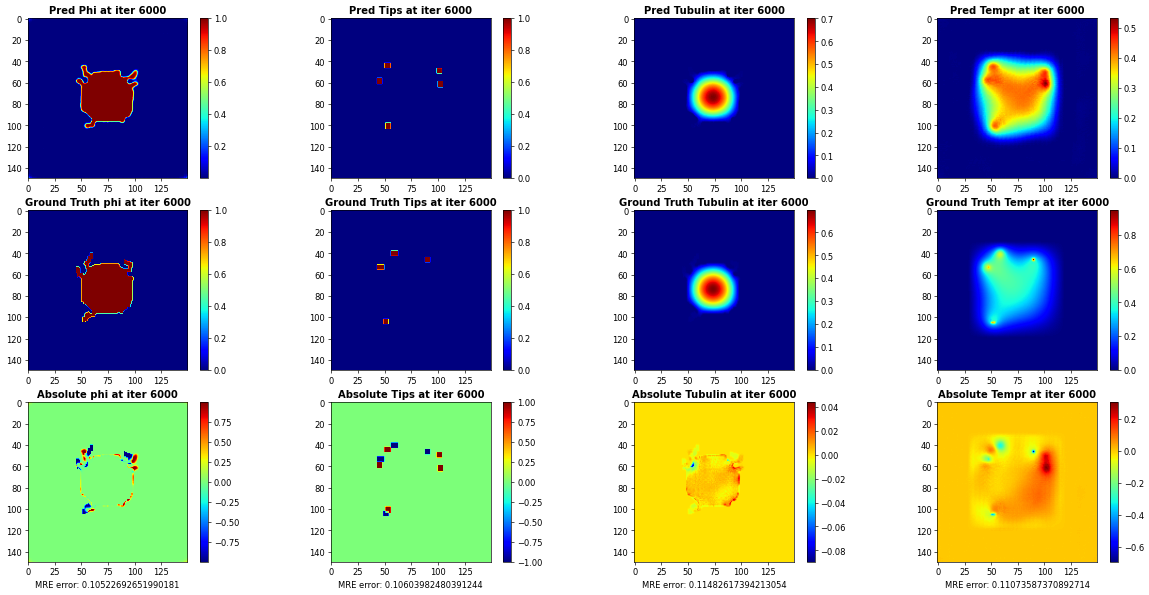

Plotting and Saving figures ...:  21%|██        | 7/34 [00:09<00:34,  1.27s/it]

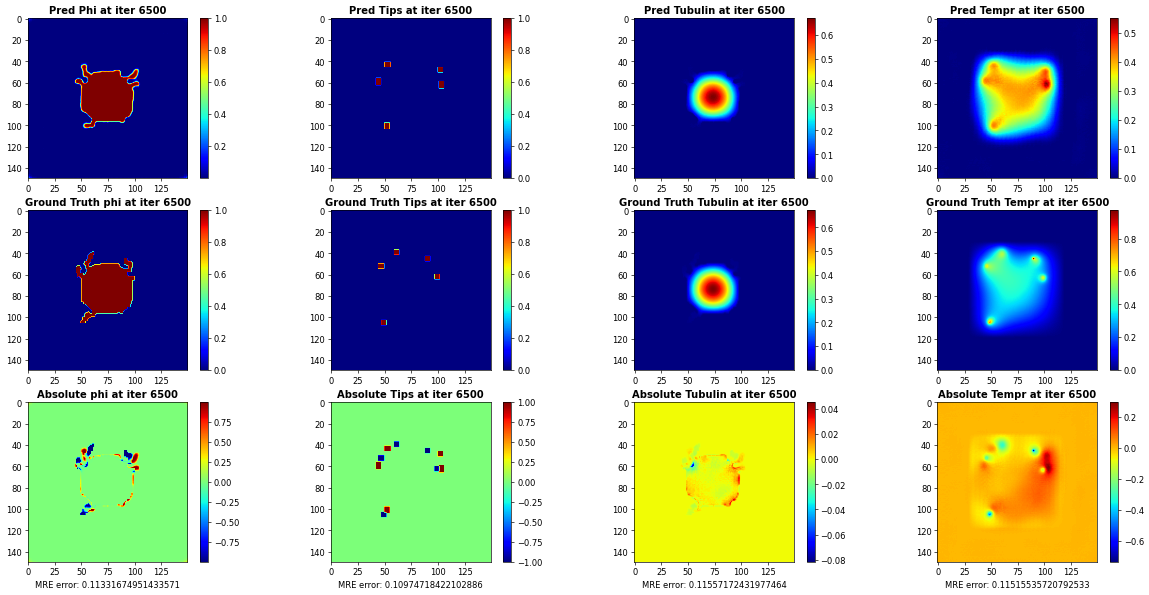

Plotting and Saving figures ...:  24%|██▎       | 8/34 [00:10<00:31,  1.21s/it]

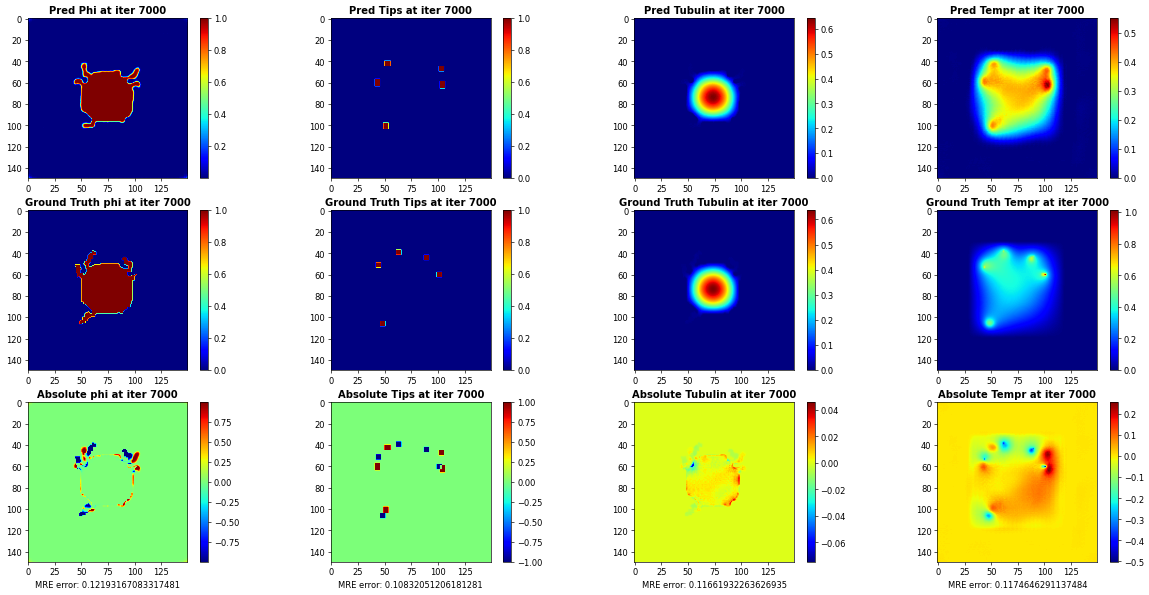

Plotting and Saving figures ...:  26%|██▋       | 9/34 [00:12<00:30,  1.23s/it]

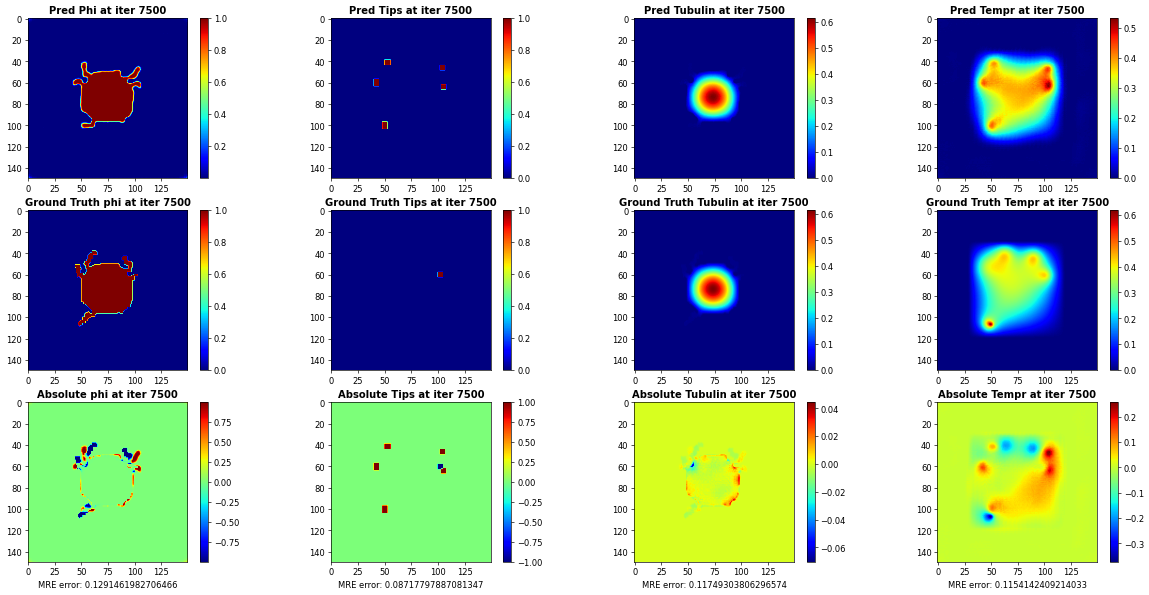

Plotting and Saving figures ...:  29%|██▉       | 10/34 [00:13<00:28,  1.18s/it]

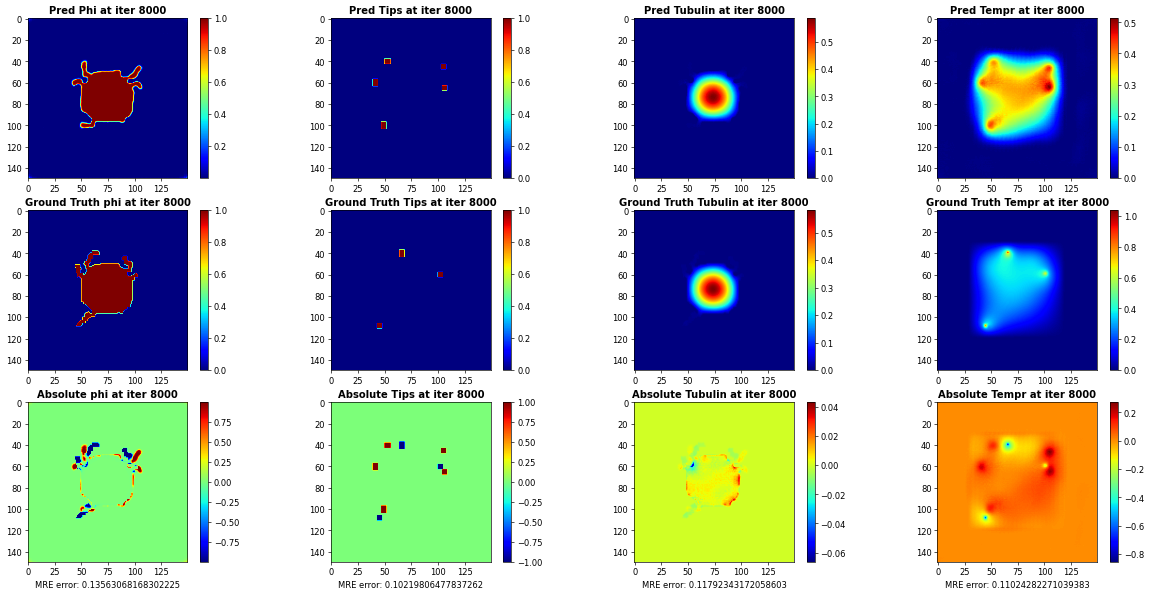

Plotting and Saving figures ...:  32%|███▏      | 11/34 [00:14<00:27,  1.19s/it]

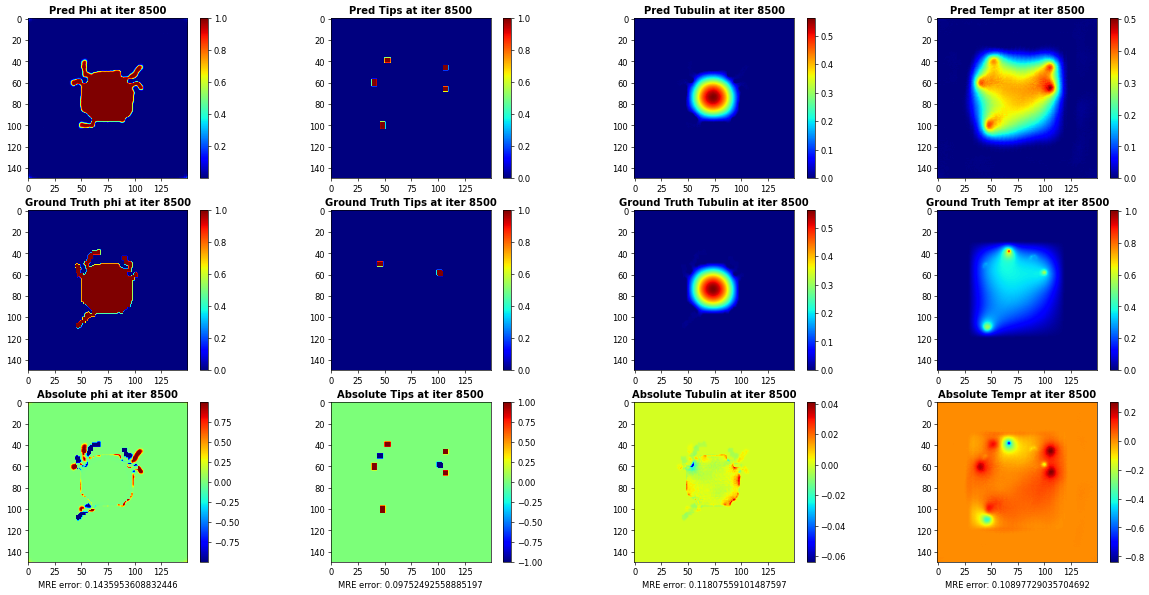

Plotting and Saving figures ...:  35%|███▌      | 12/34 [00:15<00:25,  1.15s/it]

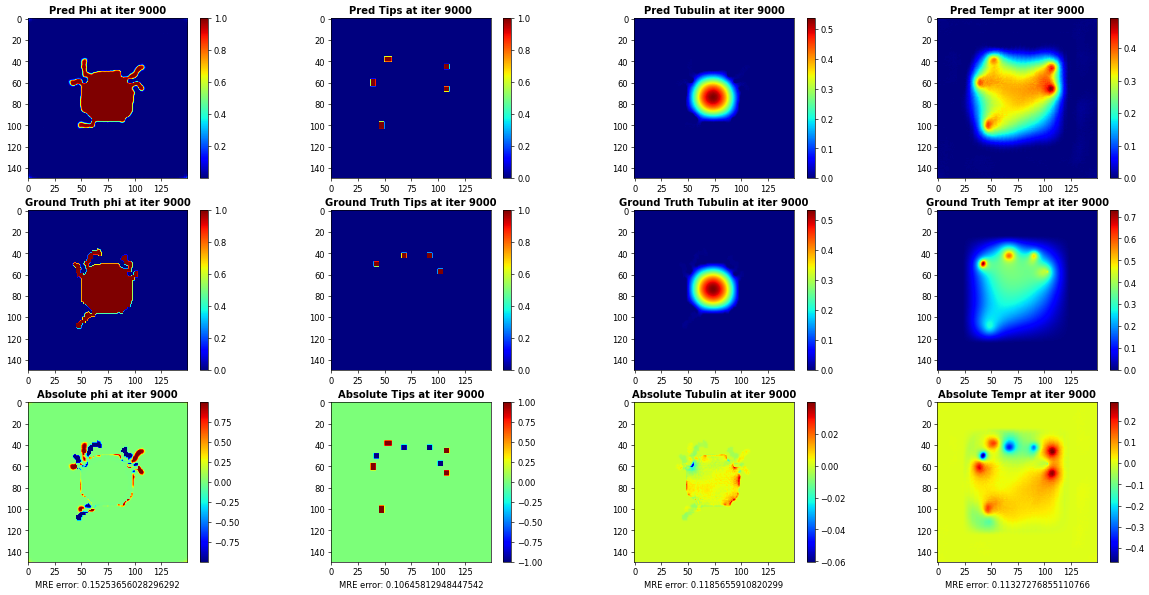

Plotting and Saving figures ...:  38%|███▊      | 13/34 [00:16<00:24,  1.17s/it]

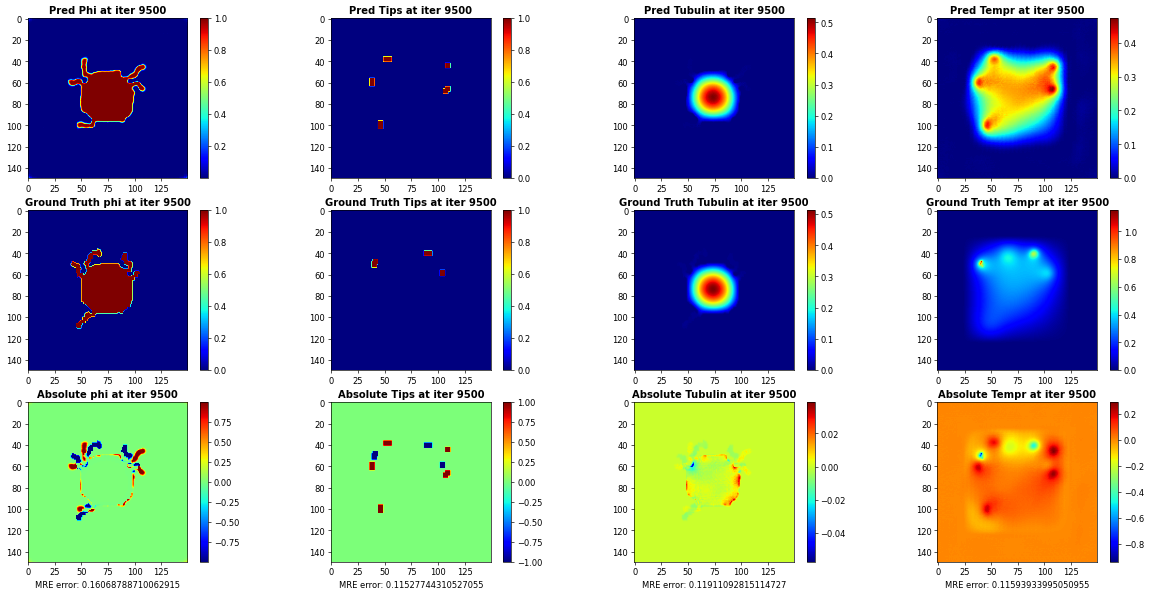

Plotting and Saving figures ...:  41%|████      | 14/34 [00:17<00:22,  1.14s/it]

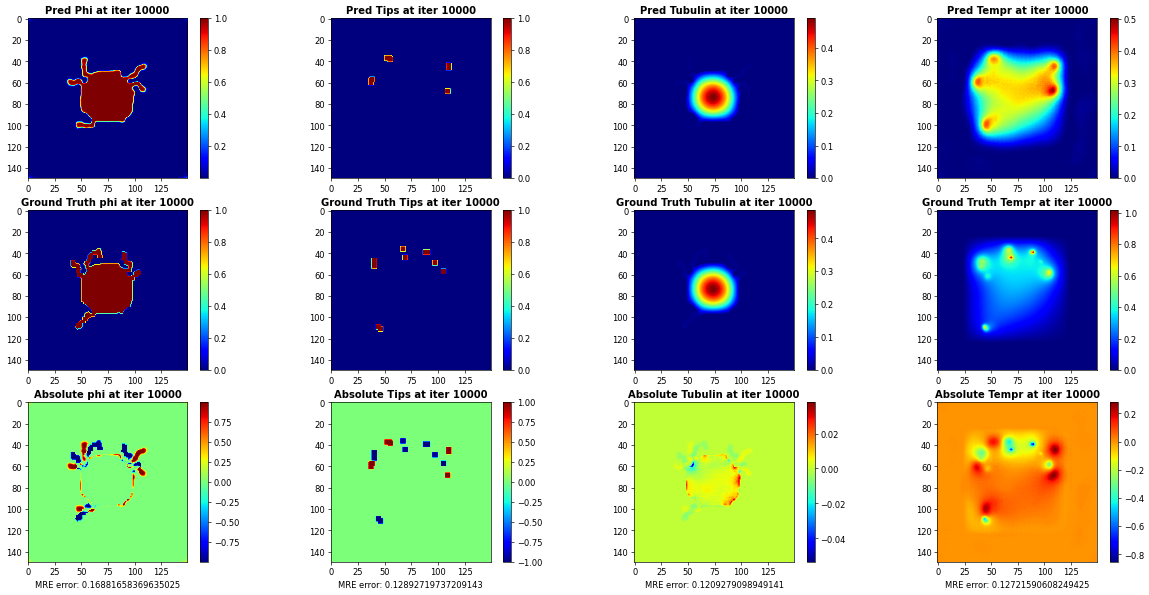

Plotting and Saving figures ...:  44%|████▍     | 15/34 [00:19<00:22,  1.19s/it]

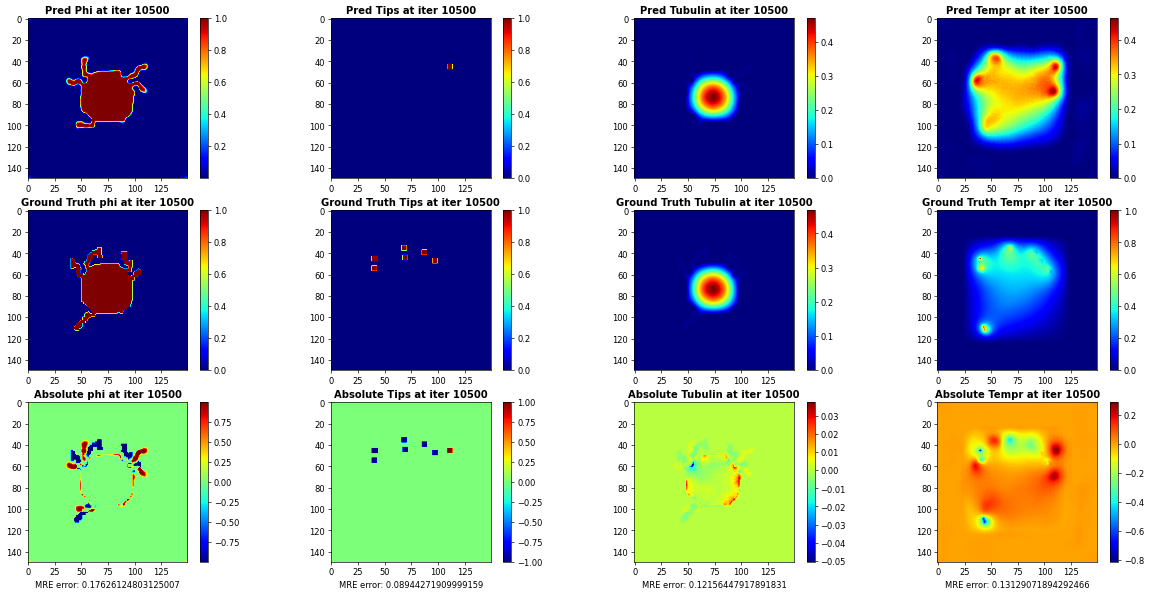

Plotting and Saving figures ...:  47%|████▋     | 16/34 [00:20<00:22,  1.23s/it]

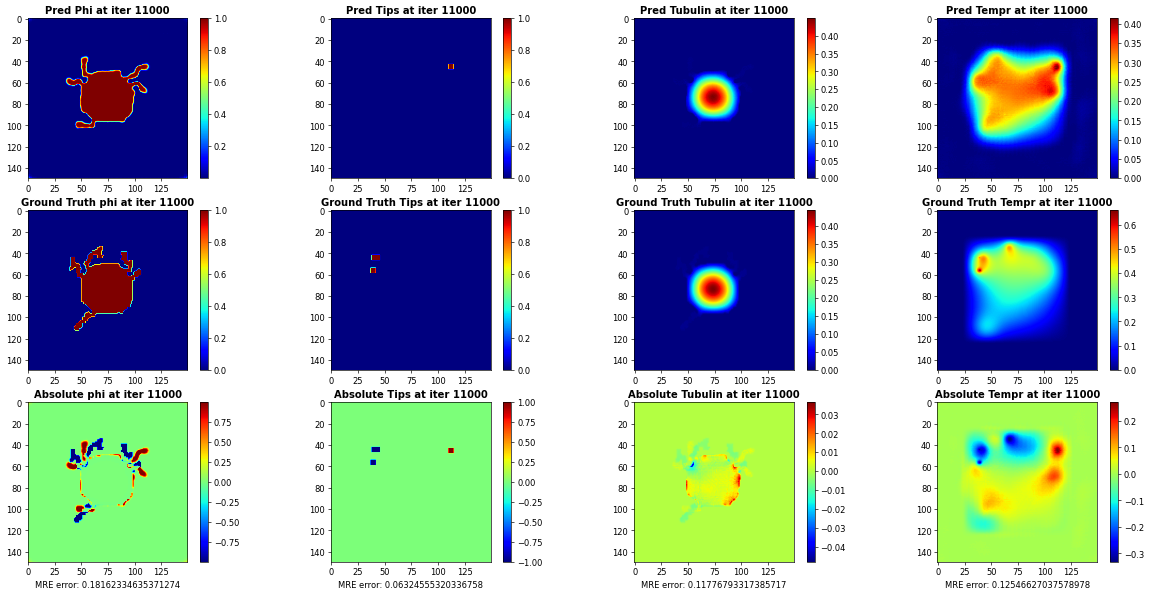

Plotting and Saving figures ...:  50%|█████     | 17/34 [00:21<00:20,  1.19s/it]

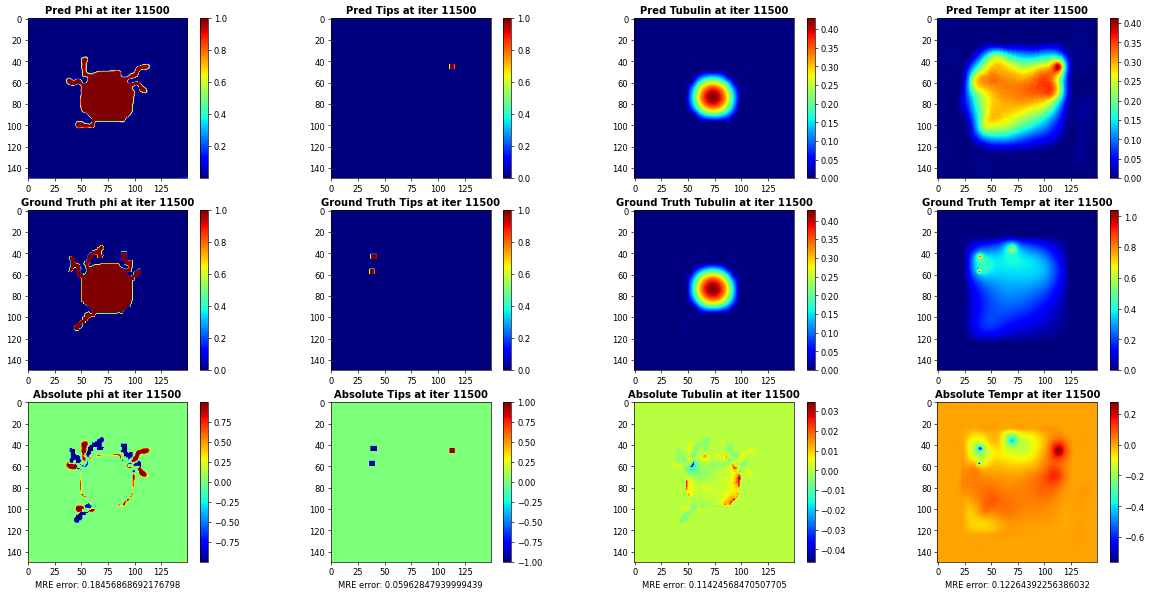

Plotting and Saving figures ...:  53%|█████▎    | 18/34 [00:22<00:19,  1.23s/it]

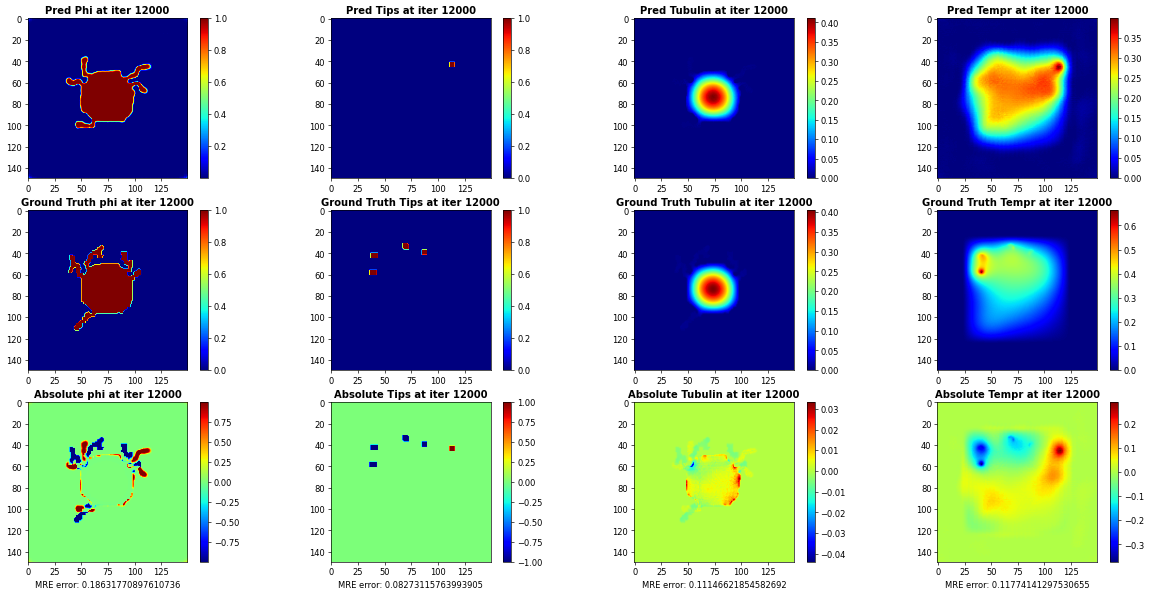

Plotting and Saving figures ...:  56%|█████▌    | 19/34 [00:24<00:17,  1.19s/it]

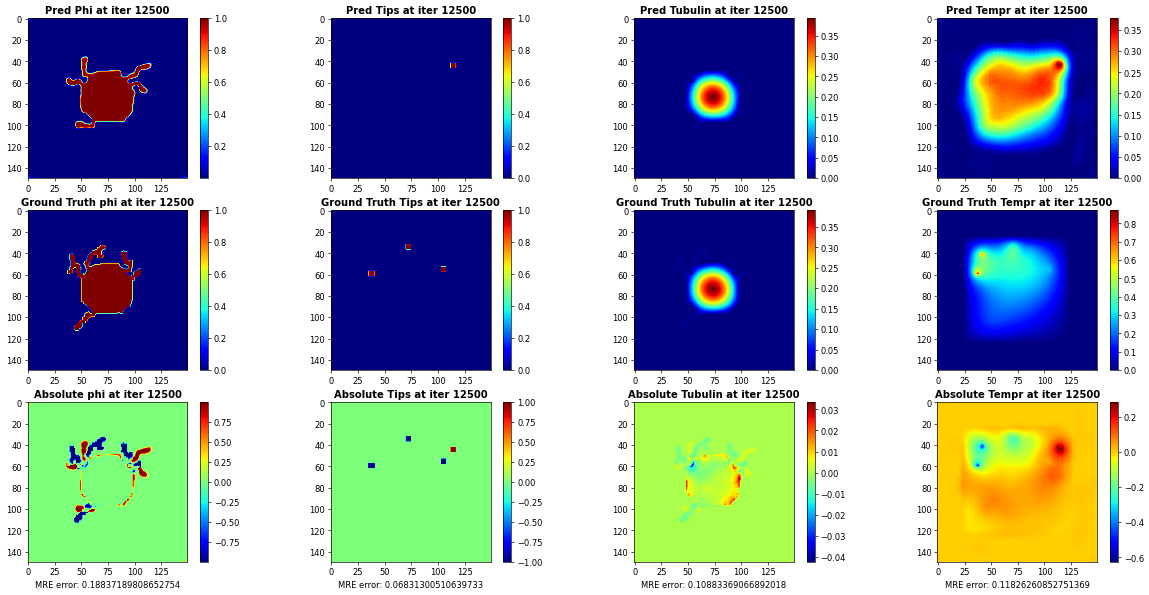

Plotting and Saving figures ...:  59%|█████▉    | 20/34 [00:25<00:17,  1.22s/it]

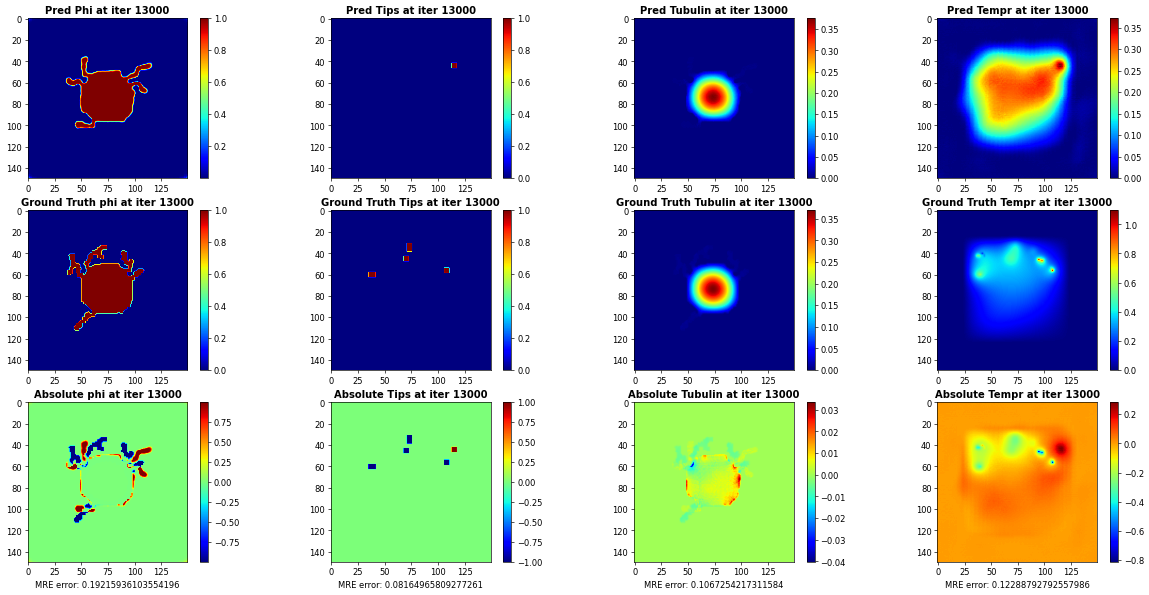

Plotting and Saving figures ...:  62%|██████▏   | 21/34 [00:26<00:15,  1.18s/it]

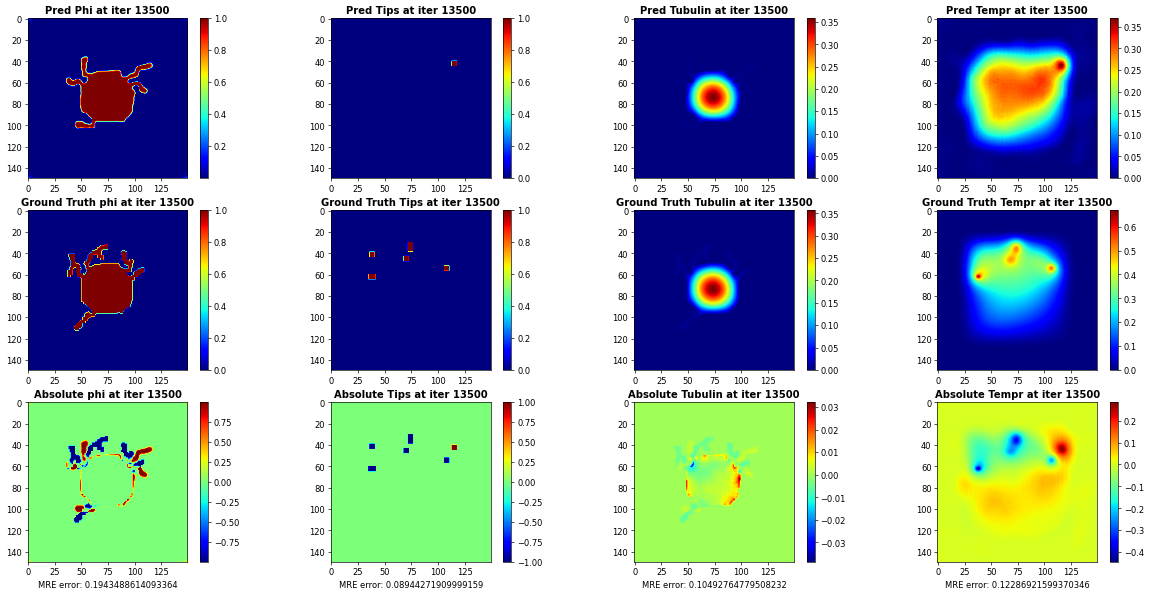

Plotting and Saving figures ...:  65%|██████▍   | 22/34 [00:27<00:14,  1.21s/it]

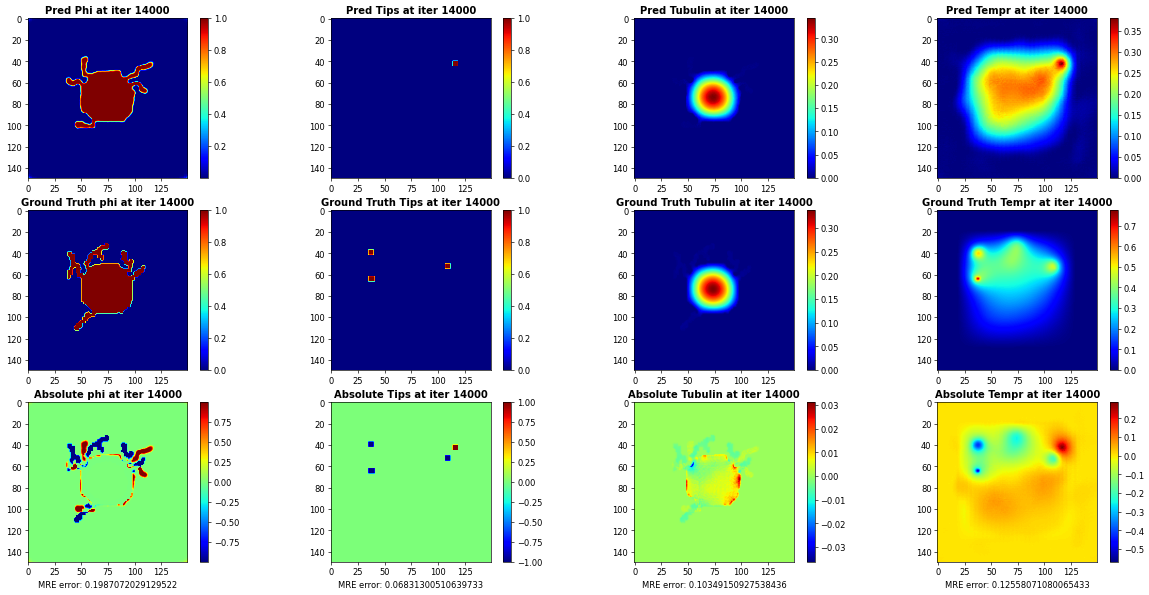

Plotting and Saving figures ...:  68%|██████▊   | 23/34 [00:28<00:12,  1.18s/it]

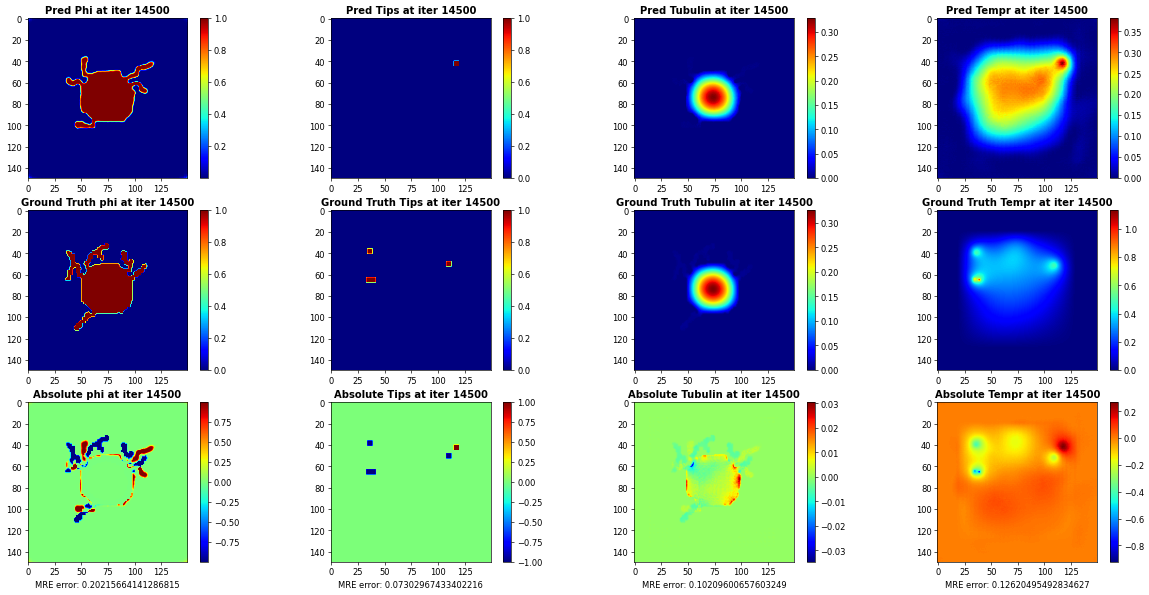

Plotting and Saving figures ...:  71%|███████   | 24/34 [00:30<00:12,  1.21s/it]

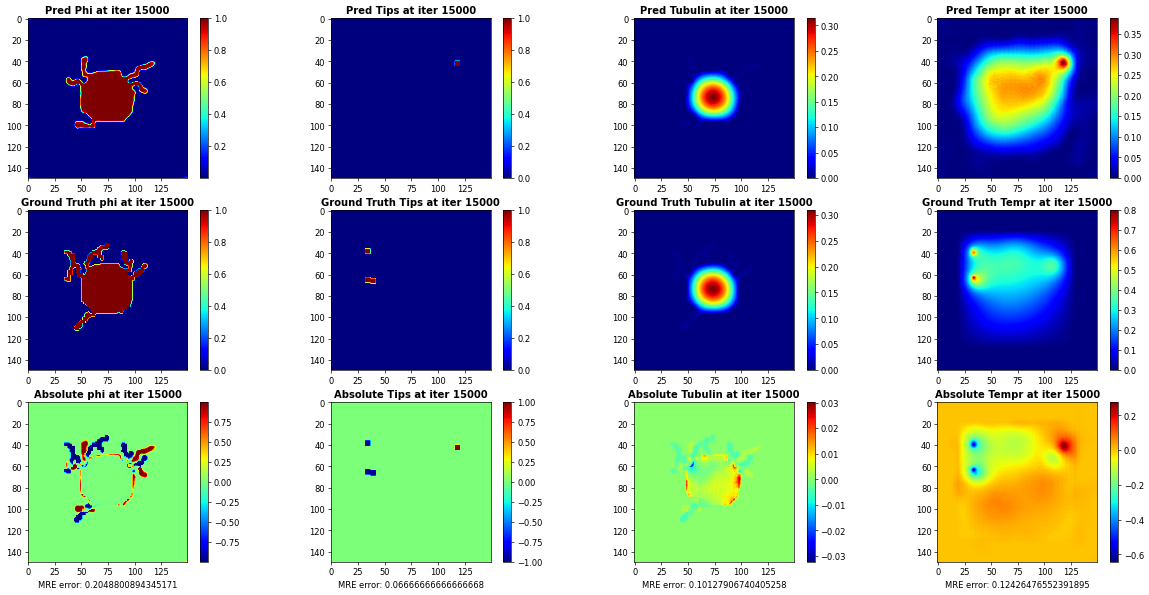

Plotting and Saving figures ...:  74%|███████▎  | 25/34 [00:31<00:10,  1.17s/it]

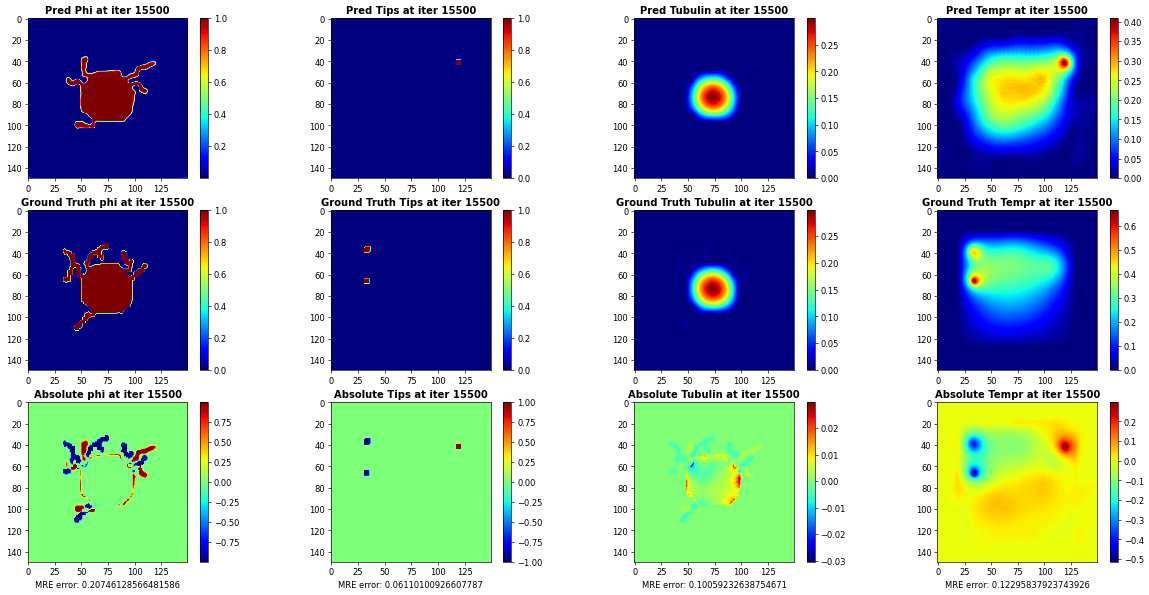

Plotting and Saving figures ...:  76%|███████▋  | 26/34 [00:32<00:09,  1.22s/it]

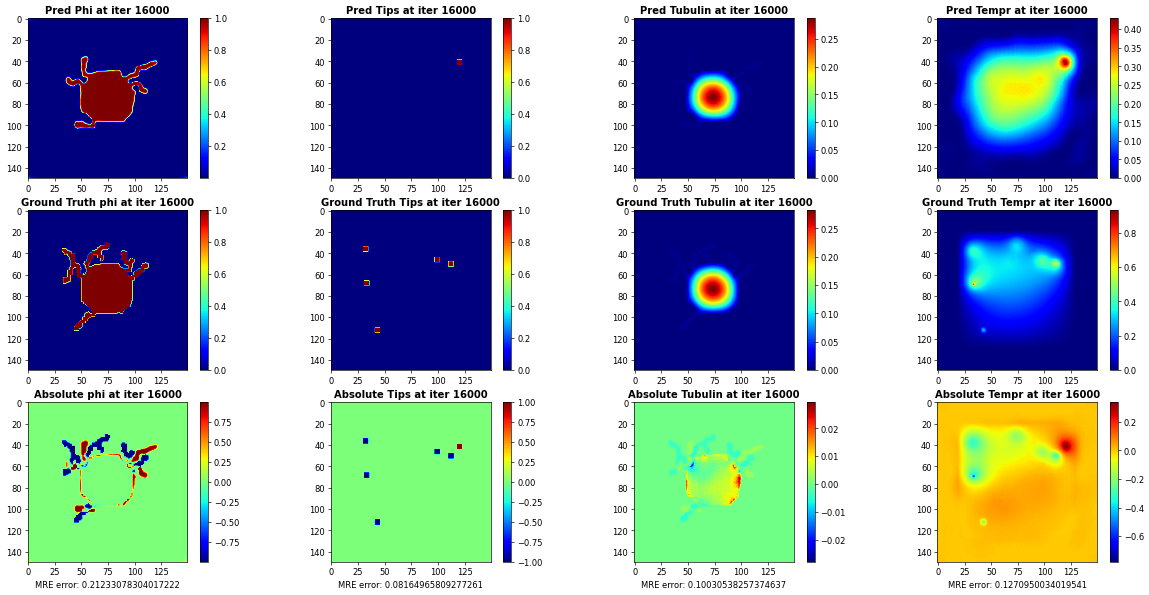

Plotting and Saving figures ...:  79%|███████▉  | 27/34 [00:33<00:08,  1.17s/it]

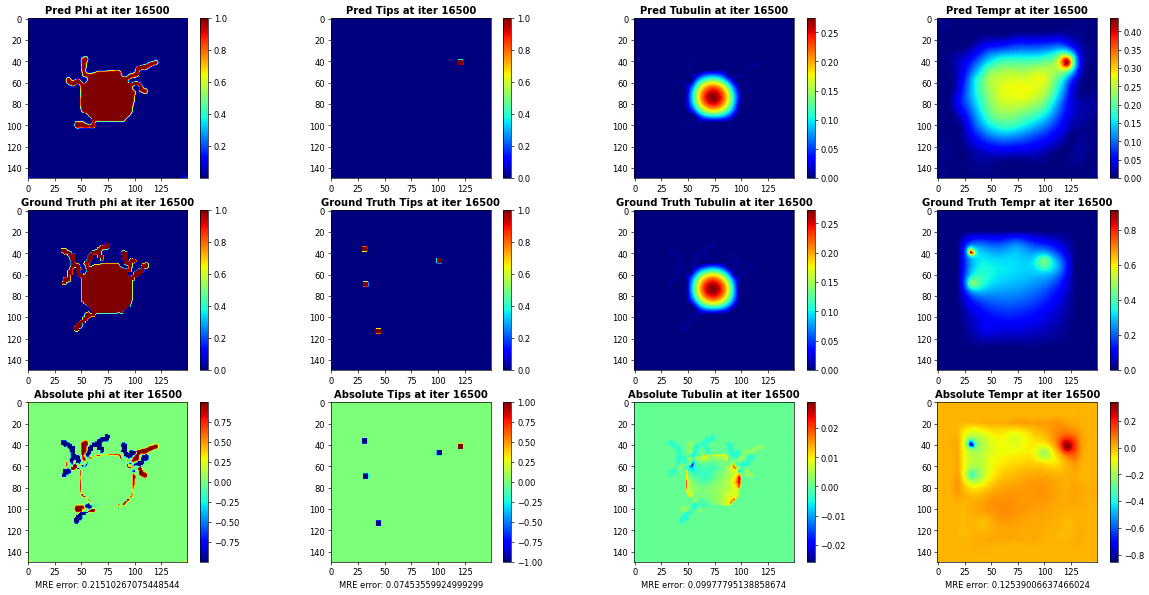

Plotting and Saving figures ...:  82%|████████▏ | 28/34 [00:34<00:07,  1.21s/it]

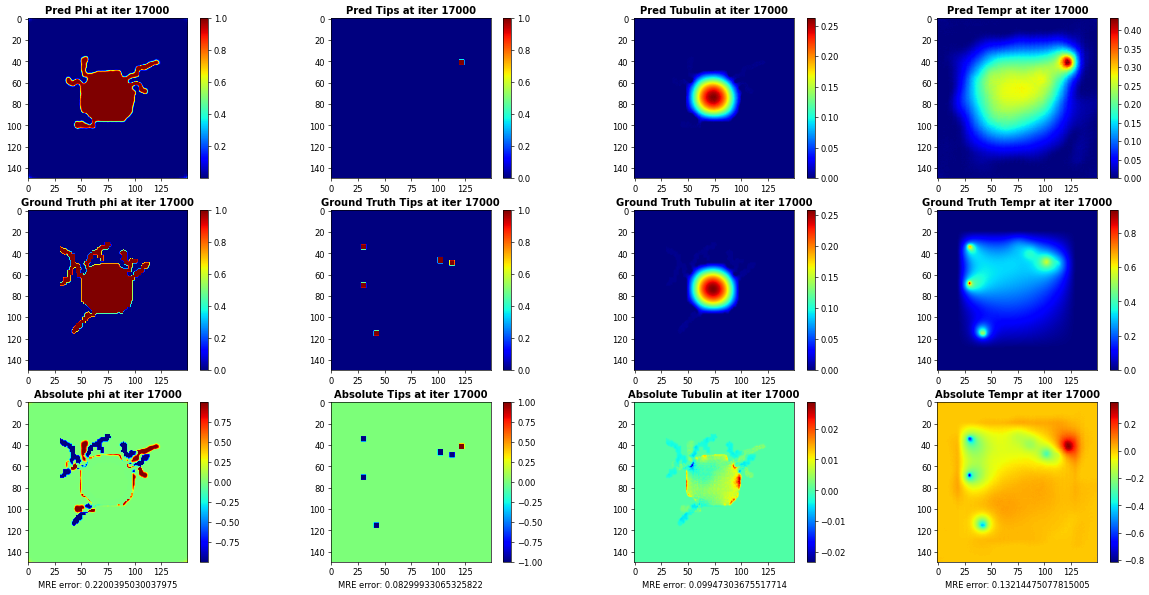

Plotting and Saving figures ...:  85%|████████▌ | 29/34 [00:36<00:06,  1.22s/it]

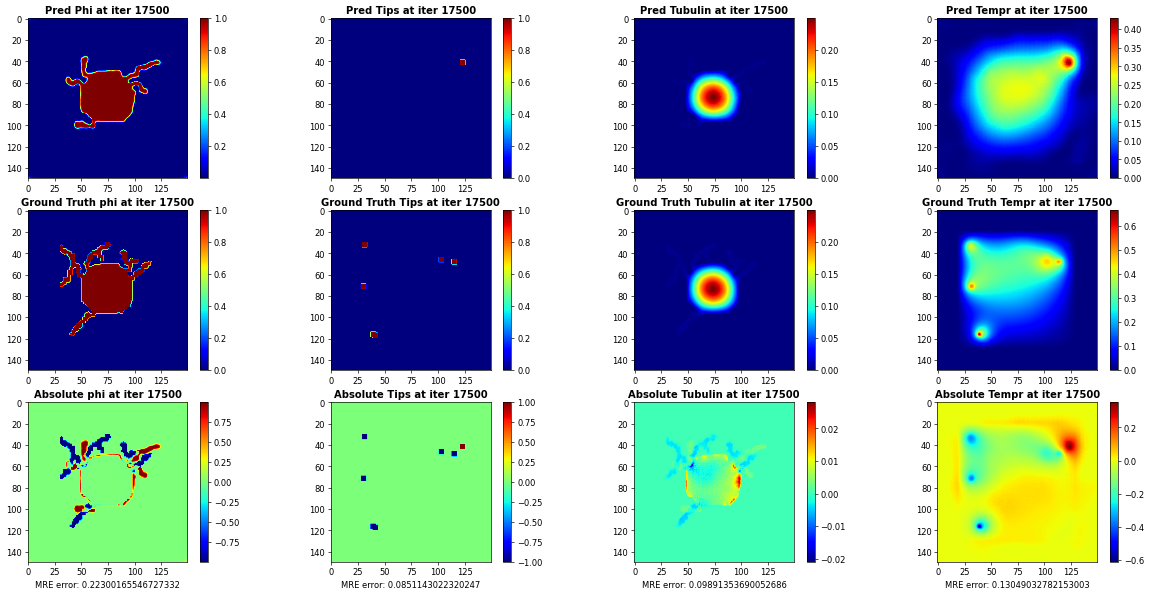

Plotting and Saving figures ...:  88%|████████▊ | 30/34 [00:37<00:04,  1.18s/it]

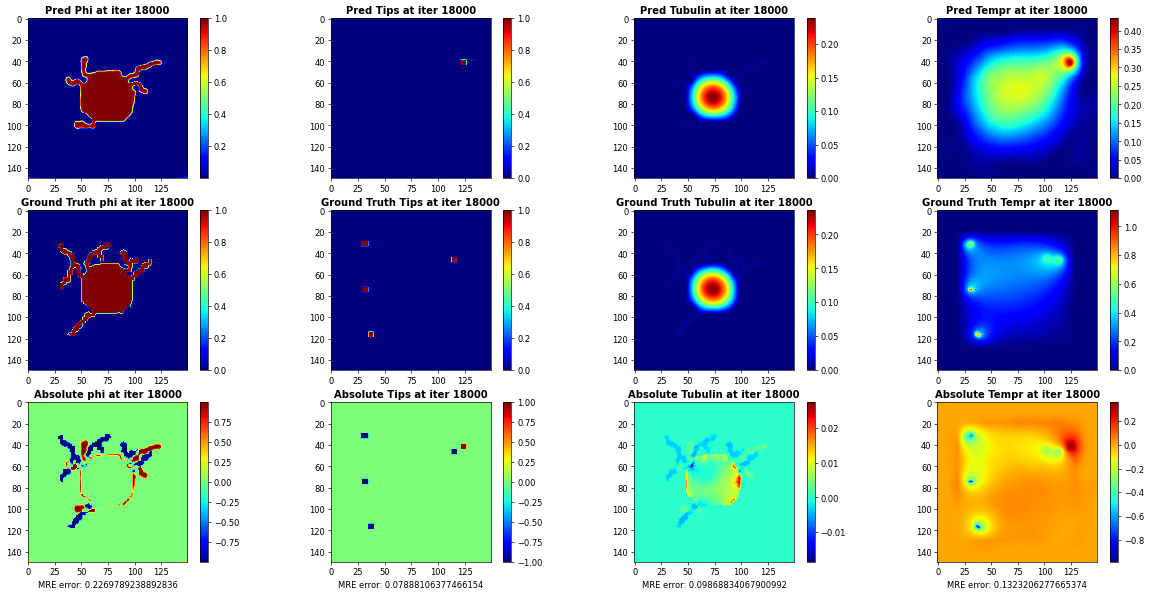

Plotting and Saving figures ...:  91%|█████████ | 31/34 [00:38<00:03,  1.22s/it]

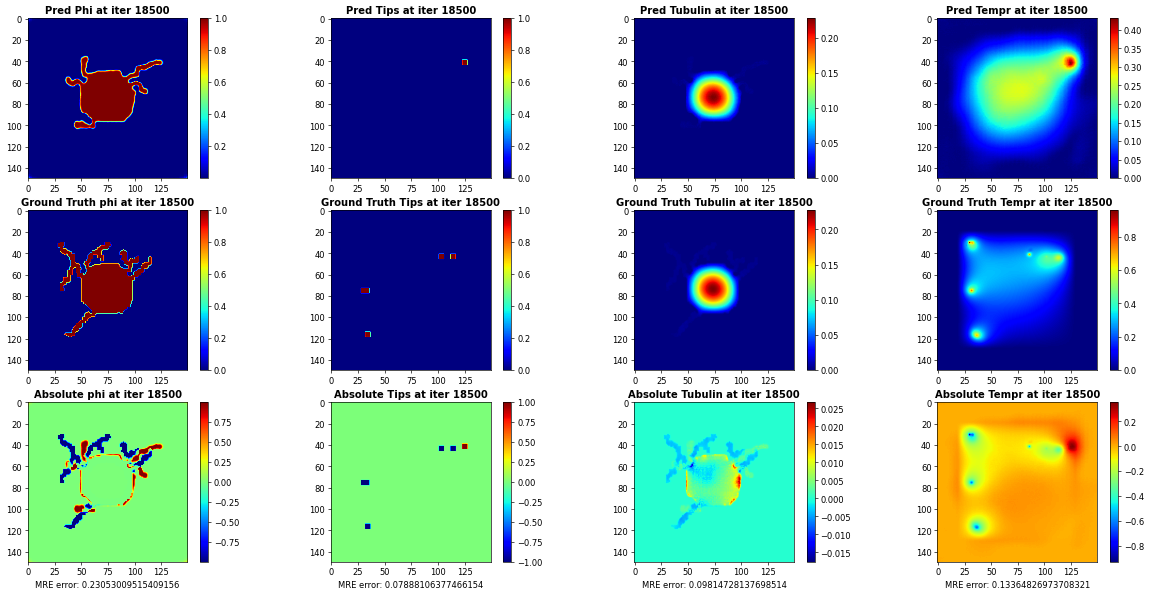

Plotting and Saving figures ...:  94%|█████████▍| 32/34 [00:39<00:02,  1.19s/it]

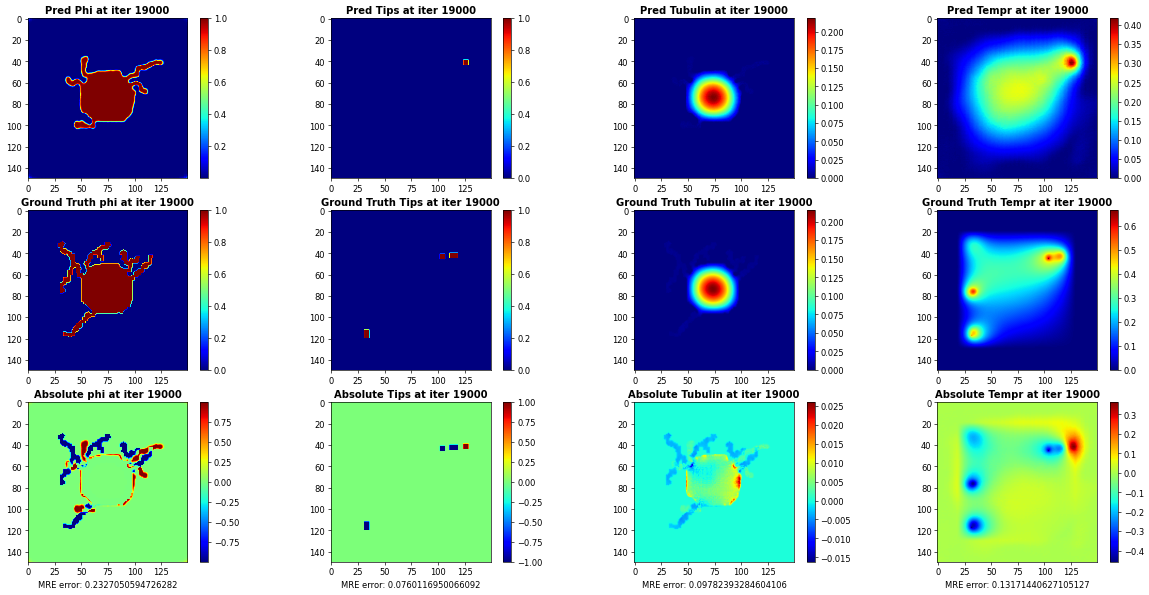

Plotting and Saving figures ...:  97%|█████████▋| 33/34 [00:40<00:01,  1.24s/it]

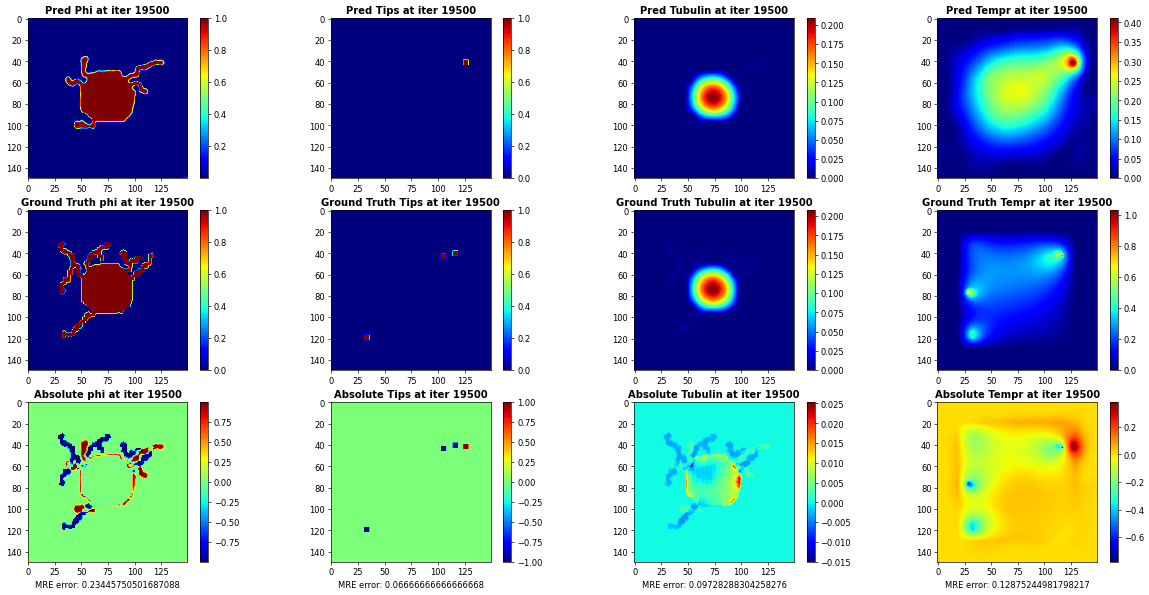

Plotting and Saving figures ...: 100%|██████████| 34/34 [00:42<00:00,  1.24s/it]


In [11]:
import copy
# start matlab engine, requires valid installation of matlab and matlab.engine library
import matlab.engine
eng = matlab.engine.start_matlab()
s = eng.genpath('Matlab_algorithm')
eng.addpath(s, nargout=0)

# calc mre between pred and goal
def get_mre(pred,goal):
    return np.sqrt(np.sum(np.square(pred-goal)/(pred.shape[0]*pred.shape[1])))

def push(input, cutoff):
    output = np.zeros(input.shape)
    output_max = np.ndarray.max(input)
    output[input>(cutoff*output_max)] = 1
    return output

# generating intial 5 frame input for predictions
rand_case = np.random.randint((len(val_dataset)))
print(f"Random case: {rand_case}")
example_x = val_dataset[rand_case,:,:,:,0:5]
x_in = np.expand_dims(example_x[0:numFrames,...],axis=0)

from tqdm import tqdm
# loop to continuously make prediction (based on lastest 5 frames)
for i in tqdm(range(34), desc="Plotting and Saving figures ..."):
    iter = (i+1)*500+2500
    # prediction
    new_prediction = model.predict(x_in,verbose="0")
    # phi = push(new_prediction[0,0,:,:,0],0.2)
    # phi = np.round(new_prediction[0,0,:,:,0])
    phi = new_prediction[0,0,:,:,0]
    tips = np.round(eng.generate_tips_for_python(matlab.double(np.array(phi).astype('float64')),iter)) # calc tips using matlab algorithm
    # tips = example_x[i+5,:,:,1]
    # tips = new_prediction[0,0,:,:,1]
    tub = new_prediction[0,0,:,:,2]
    tempr = new_prediction[0,0,:,:,3]
    theta = new_prediction[0,0,:,:,4]

    # plot prediction
    plt.figure(figsize=(25, 12), dpi=60)
    plt.gcf().set_facecolor("white")
    plt.subplot(3,4,1)
    plt.imshow(phi, cmap='jet')
    plt.colorbar()
    plt.title(f"Pred Phi at iter {iter}", fontweight='bold')
    plt.subplot(3,4,2)
    plt.imshow(tips, cmap='jet')
    plt.colorbar()
    plt.title(f"Pred Tips at iter {iter}", fontweight='bold')
    plt.subplot(3,4,3)
    plt.imshow(tub, cmap='jet')
    plt.colorbar()
    plt.title(f"Pred Tubulin at iter {iter}", fontweight='bold')
    plt.subplot(3,4,4)
    plt.imshow(tempr, cmap='jet')
    plt.colorbar()
    plt.title(f"Pred Tempr at iter {iter}", fontweight='bold')
    # plot ground truth
    plt.subplot(3,4,5)
    plt.imshow(example_x[i+5,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title(f"Ground Truth phi at iter {iter}", fontweight='bold')
    plt.subplot(3,4,6)
    plt.imshow(example_x[i+5,:,:,1], cmap='jet')
    plt.colorbar()
    plt.title(f"Ground Truth Tips at iter {iter}", fontweight='bold')
    plt.subplot(3,4,7)
    plt.imshow(example_x[i+5,:,:,2], cmap='jet')
    plt.colorbar()
    plt.title(f"Ground Truth Tubulin at iter {iter}", fontweight='bold')
    plt.subplot(3,4,8)
    plt.imshow(example_x[i+5,:,:,3], cmap='jet')
    plt.colorbar()
    plt.title(f"Ground Truth Tempr at iter {iter}", fontweight='bold')
    # calc mean relative error
    mre_phi = get_mre(phi,example_x[i+5,:,:,0])
    mre_tips = get_mre(tips,example_x[i+5,:,:,1])
    mre_tempr = get_mre(tempr,example_x[i+5,:,:,2])
    mre_tub = get_mre(tub,example_x[i+5,:,:,3])
    mre_theta = get_mre(theta,example_x[i+5,:,:,4])
    # plot error
    plt.subplot(3,4,9)
    plt.imshow(phi-example_x[i+5,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title(f"Absolute phi at iter {iter}", fontweight='bold')
    plt.xlabel(f"MRE error: {mre_phi}")
    plt.subplot(3,4,10)
    plt.imshow(tips-example_x[i+5,:,:,1], cmap='jet')
    plt.colorbar()
    plt.title(f"Absolute Tips at iter {iter}", fontweight='bold')
    plt.xlabel(f"MRE error: {mre_tips}")
    plt.subplot(3,4,11)
    plt.imshow(tub-example_x[i+5,:,:,2], cmap='jet')
    plt.colorbar()
    plt.title(f"Absolute Tubulin at iter {iter}", fontweight='bold')
    plt.xlabel(f"MRE error: {mre_tempr}")
    plt.subplot(3,4,12)
    plt.imshow(tempr-example_x[i+5,:,:,3], cmap='jet')
    plt.colorbar()
    plt.title(f"Absolute Tempr at iter {iter}", fontweight='bold')
    plt.xlabel(f"MRE error: {mre_tub}")
    # save fig
    # plt.savefig(f"gif/{iter:05d}.png")
    plt.show()

    # update prediction for later use as input (shifting)
    tmp_var = copy.copy(new_prediction)
    tmp_var[0,-1,:,:,0] = phi
    tmp_var[0,-1,:,:,1] = tips
    tmp = np.zeros(x_in.shape)
    for j in range(numFrames-1):
        tmp[0,j,...] = x_in[0,j+1,...]
    tmp[0,-1,:,:,:] = tmp_var
    x_in = tmp

eng.quit()

In [12]:
import copy
# start matlab engine, requires valid installation of matlab and matlab.engine library
import matlab.engine
eng = matlab.engine.start_matlab()
s = eng.genpath('Matlab_algorithm')
eng.addpath(s, nargout=0)

# calc mre between pred and goal
def get_mre(pred,goal):
    return np.sqrt(np.sum(np.square(pred-goal)/(pred.shape[0]*pred.shape[1])))

def push(input, cutoff):
    input = input.numpy()
    max_input = np.amax(input)
    output = copy.copy(input)
    output[input>(cutoff*max_input)] = 1
    output[input<=(cutoff*max_input)] = 0
    return output

def push_1(input):
    input = input.numpy()
    max_input = np.amax(input)
    ratio = 1/max_input
    output = input*ratio
    return output

# generating intial 5 frame input for predictions
rand_case = np.random.randint((len(val_dataset)))

# for rand_case in tqdm(range(len(val_dataset)), desc="Plotting and Saving figures ..."):
print(f"Random case: {rand_case}")
example_x = val_dataset[rand_case,:,:,:,0:5]
x_in = np.expand_dims(example_x[0:numFrames,...],axis=0)

# loop to continuously make prediction (based on lastest 5 frames)
for i in range(64):
    iter = (i+1)*500+2500
    # prediction
    model = keras.models.load_model('./saved_model/model_conv_lstm_test_42_weighted', custom_objects={'loss': PINN_loss()})
    new_prediction = model.predict(x_in,verbose="0")
    tf.keras.backend.clear_session()
    phi = new_prediction[0,0,:,:,0]

    if (iter<10500) or (iter>28500):
        iter_mat = np.expand_dims(np.expand_dims(np.ones(phi.shape),axis=0),axis=3)
    else:
        iter_mat = np.expand_dims(np.expand_dims(np.zeros(phi.shape),axis=0),axis=3)
        
    tub = new_prediction[0,0,:,:,2]
    tempr = new_prediction[0,0,:,:,3]
    theta = new_prediction[0,0,:,:,4]

    model = keras.models.load_model('./saved_model/tipsCNN_predBased_1')
    # tips = np.round(model(np.expand_dims(np.concatenate((np.expand_dims(phi,axis=2),np.expand_dims(iter_mat,axis=2)),axis=2),axis=0))[0,:,:,0])
    tips = np.expand_dims(np.concatenate((np.expand_dims(phi,axis=2),np.expand_dims(theta,axis=2)),axis=2),axis=0)
    tips = model(tips)[0,:,:,0]
    tips = push(tips,0.5)
    tf.keras.backend.clear_session()
    
    # tips = np.round(eng.generate_tips_for_python(matlab.double(np.array(phi).astype('float64')),iter)) # calc tips using matlab algorithm
    # tips = push(new_prediction[0,0,:,:,1],0.9)
    # tips = example_x[i+5,:,:,1]

    # plot prediction
    plt.figure(figsize=(25, 12), dpi=60)
    plt.gcf().set_facecolor("white")
    plt.subplot(3,4,1)
    plt.imshow(phi, cmap='jet')
    plt.colorbar()
    plt.title(f"Pred Phi at iter {iter}", fontweight='bold')
    plt.subplot(3,4,2)
    plt.imshow(tips, cmap='jet')
    plt.colorbar()
    plt.title(f"Pred Tips at iter {iter}", fontweight='bold')
    plt.subplot(3,4,3)
    plt.imshow(tub, cmap='jet')
    plt.colorbar()
    plt.title(f"Pred Tubulin at iter {iter}", fontweight='bold')
    plt.subplot(3,4,4)
    plt.imshow(tempr, cmap='jet')
    plt.colorbar()
    plt.title(f"Pred Tempr at iter {iter}", fontweight='bold')
    # plot ground truth
    plt.subplot(3,4,5)
    plt.imshow(example_x[i+5,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title(f"Ground Truth phi at iter {iter}", fontweight='bold')
    plt.subplot(3,4,6)
    plt.imshow(example_x[i+5,:,:,1], cmap='jet')
    plt.colorbar()
    plt.title(f"Ground Truth Tips at iter {iter}", fontweight='bold')
    plt.subplot(3,4,7)
    plt.imshow(example_x[i+5,:,:,2], cmap='jet')
    plt.colorbar()
    plt.title(f"Ground Truth Tubulin at iter {iter}", fontweight='bold')
    plt.subplot(3,4,8)
    plt.imshow(example_x[i+5,:,:,3], cmap='jet')
    plt.colorbar()
    plt.title(f"Ground Truth Tempr at iter {iter}", fontweight='bold')
    # calc mean relative error
    mre_phi = get_mre(phi,example_x[i+5,:,:,0])
    mre_tips = get_mre(tips,example_x[i+5,:,:,1])
    mre_tempr = get_mre(tempr,example_x[i+5,:,:,2])
    mre_tub = get_mre(tub,example_x[i+5,:,:,3])
    mre_theta = get_mre(theta,example_x[i+5,:,:,4])
    # plot error
    plt.subplot(3,4,9)
    plt.imshow(phi-example_x[i+5,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title(f"Absolute phi at iter {iter}", fontweight='bold')
    plt.xlabel(f"MRE error: {mre_phi}")
    plt.subplot(3,4,10)
    plt.imshow(tips-example_x[i+5,:,:,1], cmap='jet')
    plt.colorbar()
    plt.title(f"Absolute Tips at iter {iter}", fontweight='bold')
    plt.xlabel(f"MRE error: {mre_tips}")
    plt.subplot(3,4,11)
    plt.imshow(tub-example_x[i+5,:,:,2], cmap='jet')
    plt.colorbar()
    plt.title(f"Absolute Tubulin at iter {iter}", fontweight='bold')
    plt.xlabel(f"MRE error: {mre_tempr}")
    plt.subplot(3,4,12)
    plt.imshow(tempr-example_x[i+5,:,:,3], cmap='jet')
    plt.colorbar()
    plt.title(f"Absolute Tempr at iter {iter}", fontweight='bold')
    plt.xlabel(f"MRE error: {mre_tub}")
    # save fig
    # plt.savefig(f"gif/{iter:05d}.png")
    plt.show()

    # update prediction for later use as input (shifting)
    tmp_var = copy.copy(new_prediction)
    tmp_var[0,-1,:,:,0] = phi
    tmp_var[0,-1,:,:,1] = tips
    tmp = np.zeros(x_in.shape)
    for j in range(numFrames-1):
        tmp[0,j,...] = x_in[0,j+1,...]
    tmp[0,-1,:,:,:] = tmp_var
    x_in = tmp

# # plot prediction
# plt.figure(figsize=(25, 12), dpi=60)
# plt.gcf().set_facecolor("white")
# plt.subplot(3,4,1)
# plt.imshow(phi, cmap='jet')
# plt.colorbar()
# plt.title(f"Pred Phi at iter {iter}", fontweight='bold')
# plt.subplot(3,4,2)
# plt.imshow(tips, cmap='jet')
# plt.colorbar()
# plt.title(f"Pred Tips at iter {iter}", fontweight='bold')
# plt.subplot(3,4,3)
# plt.imshow(tub, cmap='jet')
# plt.colorbar()
# plt.title(f"Pred Tubulin at iter {iter}", fontweight='bold')
# plt.subplot(3,4,4)
# plt.imshow(tempr, cmap='jet')
# plt.colorbar()
# plt.title(f"Pred Tempr at iter {iter}", fontweight='bold')
# # plot ground truth
# plt.subplot(3,4,5)
# plt.imshow(example_x[i+5,:,:,0], cmap='jet')
# plt.colorbar()
# plt.title(f"Ground Truth phi at iter {iter}", fontweight='bold')
# plt.subplot(3,4,6)
# plt.imshow(example_x[i+5,:,:,1], cmap='jet')
# plt.colorbar()
# plt.title(f"Ground Truth Tips at iter {iter}", fontweight='bold')
# plt.subplot(3,4,7)
# plt.imshow(example_x[i+5,:,:,2], cmap='jet')
# plt.colorbar()
# plt.title(f"Ground Truth Tubulin at iter {iter}", fontweight='bold')
# plt.subplot(3,4,8)
# plt.imshow(example_x[i+5,:,:,3], cmap='jet')
# plt.colorbar()
# plt.title(f"Ground Truth Tempr at iter {iter}", fontweight='bold')
# # calc mean relative error
# mre_phi = get_mre(phi,example_x[i+5,:,:,0])
# mre_tips = get_mre(tips,example_x[i+5,:,:,1])
# mre_tempr = get_mre(tempr,example_x[i+5,:,:,2])
# mre_tub = get_mre(tub,example_x[i+5,:,:,3])
# mre_theta = get_mre(theta,example_x[i+5,:,:,4])
# # plot error
# plt.subplot(3,4,9)
# plt.imshow(phi-example_x[i+5,:,:,0], cmap='jet')
# plt.colorbar()
# plt.title(f"Absolute phi at iter {iter}", fontweight='bold')
# plt.xlabel(f"MRE error: {mre_phi}")
# plt.subplot(3,4,10)
# plt.imshow(tips-example_x[i+5,:,:,1], cmap='jet')
# plt.colorbar()
# plt.title(f"Absolute Tips at iter {iter}", fontweight='bold')
# plt.xlabel(f"MRE error: {mre_tips}")
# plt.subplot(3,4,11)
# plt.imshow(tub-example_x[i+5,:,:,2], cmap='jet')
# plt.colorbar()
# plt.title(f"Absolute Tubulin at iter {iter}", fontweight='bold')
# plt.xlabel(f"MRE error: {mre_tempr}")
# plt.subplot(3,4,12)
# plt.imshow(tempr-example_x[i+5,:,:,3], cmap='jet')
# plt.colorbar()
# plt.title(f"Absolute Tempr at iter {iter}", fontweight='bold')
# plt.xlabel(f"MRE error: {mre_tub}")
# # save fig
# # plt.savefig(f"gif/combinedModel/{rand_case:05d}.png")

Random case: 15


OSError: No file or directory found at ./saved_model/model_conv_lstm_test_42_weighted